In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

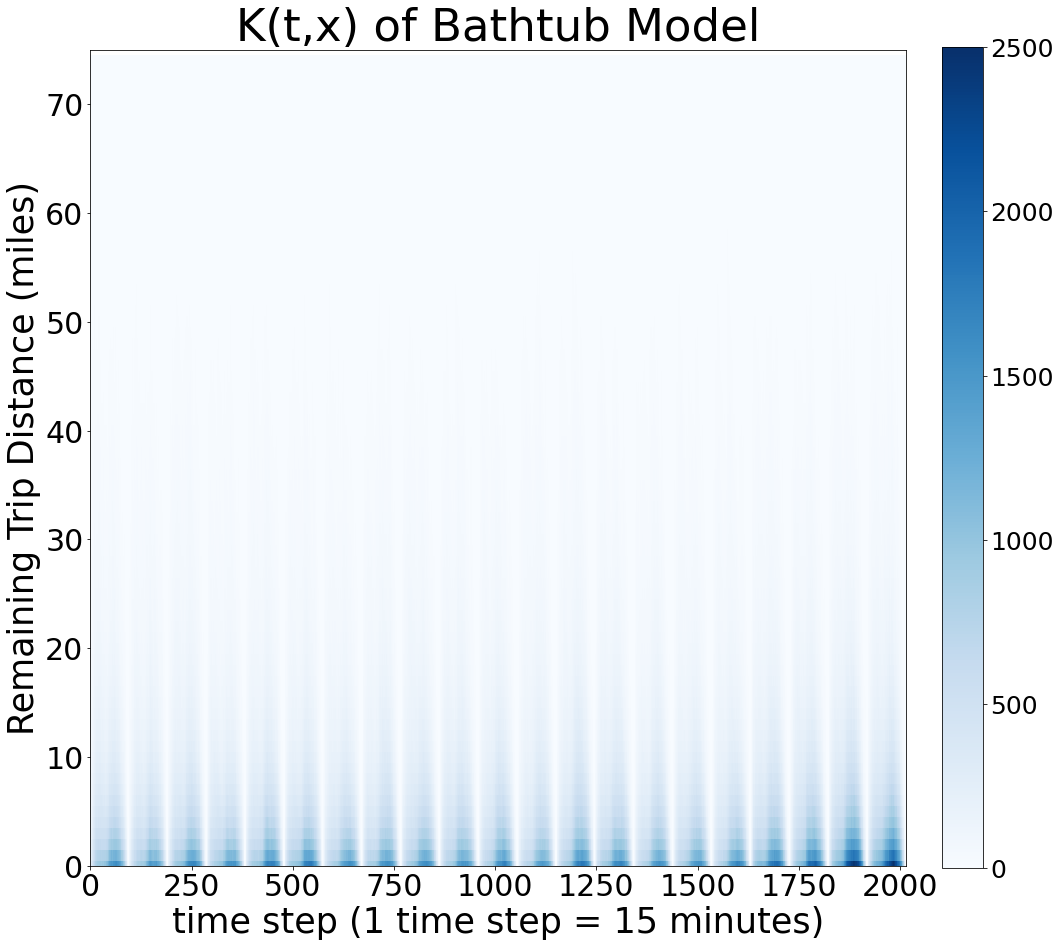

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0071848691225814658 0.010051887564633216 0.0043178506805297149 0.7667965266020336
0.00532084820841833 0.0099557292828163033 0.00068596713402035623 0.7672554295668688
0.0052144965646827614 0.010014807023939481 0.0004141861054260419 0.7694852625228593
0.00519831735314884 0.0099947496021976483 0.0004018851041000317 0.7685404551303036
0.005151646955829336 0.009897238771883022 0.0004060551397756495 0.7643529684293777
0.0050783447516103255 0.0097015813935621871 0.00045510810965846375 0.7560709718697937
0.0050049189466133525 0.009507667821998543 0.00050217007122816228 0.7479162717309491
0.00494804091419006 0.0093770965016988575 0.00051898532668126333 0.7423344411180739
0.0048889770857671946 0.0092530648035407427 0.00052488936799364614 0.737379141415177
0.004788883860620952 0.0090402025833837517 0.00053756513785815213 0.729071382122458
0.00462832912849346 0.00851867452660176 0.00073798373038516 0.7088831620602164
0.004512273352178282 0.0083882734561034032 0.00063627324825316133 0.70393111798

0.0032027680592403335 0.0054899832452145044 0.00091555287326616286 0.573241879918686
0.0032009843593792781 0.0055018731237103042 0.00090009559504825195 0.5738575955581362
0.0031996770395980069 0.0055029672217612952 0.00089638685743471881 0.5738441301205939
0.0031971205880354046 0.0054935530194153695 0.00090068815665543967 0.5733881483562389
0.0031957246321793762 0.0055104194082374767 0.0008810298561212754 0.574236024934963
0.0031936266705299824 0.0054523430628160841 0.00093491027824388069 0.5713148996685015
0.0031917750214484819 0.005487877086530972 0.00089567295636599131 0.572920039659202
0.0031916235122293971 0.0054691928266604323 0.0009140541977983623 0.5720386036853942
0.0031886968308672296 0.0054664791470071363 0.00091091451472732324 0.5719281174155637
0.0031881565583448662 0.0054556420786542933 0.00092067103803543913 0.5713618777492986
0.0031877175275417868 0.0054615155365574262 0.00091391951852614738 0.5716370229577035
0.0031869133669351598 0.005452271960592411 0.000921554773277

0.003167082011258229 0.0054359788155344656 0.00089818520698199222 0.5697450820699747
0.0031668232760437027 0.0054361016607461267 0.00089754489134127847 0.5697239876253185
0.0031667294926105288 0.0054261602409947512 0.00090729874422630619 0.5691775379147789
0.00316657815462903 0.0054216942839284054 0.00091146202532965432 0.5689839776687017
0.0031664059908993979 0.005428565665527599 0.00090424631627119645 0.5693719296350497
0.0031661509305388963 0.0054344304742723424 0.00089787138680545 0.5696194496941563
0.0031657084733081797 0.0054329043566308565 0.00089851258998550269 0.5695274838570599
0.0031651023075249742 0.00542237299375745 0.0009078316212924977 0.5689854566729521
0.0031646498039358448 0.0054183831448730516 0.000910916462998638 0.5687796412059791
0.0031642178681643368 0.0054060332377247758 0.00092240249860389765 0.5681703835314841
0.0031637207014398048 0.0054086398614056124 0.00091880154147399738 0.5683122585833037
0.0031633125208556613 0.0054052116074208272 0.00092141343429049554

0.00311544308888412 0.0053544995763641417 0.00087638660140409855 0.5652786539348836
0.0031139738815403094 0.0053351175436046738 0.00089283021947594464 0.5642342491077835
0.003113518859845761 0.0053728595147133906 0.00085417820497813129 0.5661813381656474
0.0031124125819018619 0.0053304757982500237 0.0008943493655537 0.5639415424930446
0.0031114889788130375 0.0053217796508140281 0.00090119830681204645 0.5635141420329111
0.0031106329335828767 0.0053433245837904066 0.00087794128337534709 0.5646380760551531
0.0031092942499269176 0.0053374138164617229 0.00088117468339211252 0.5643060367255168
0.0031070959302592362 0.0053279574253142069 0.00088623443520426581 0.5638015355111075
0.0031060498719974391 0.0053098650419854433 0.00090223470200943531 0.5625858181925742
0.0031042807534996664 0.0053307403613184878 0.00087782114568084476 0.5638552955869837
0.0031022936225551133 0.0053139074686583895 0.000890679776451837 0.5628953014158095
0.0031011290392116159 0.0053224023331272718 0.00087985574529596

0.0030622485690579718 0.0052787755328061407 0.000845721605309803 0.5608511752955901
0.0030621341781651339 0.00527144949160512 0.0008528188647251478 0.5604405257036346
0.0030620716140035507 0.005271369895422537 0.00085277333258456463 0.5604554120486108
0.0030620059382666211 0.0052718646857783137 0.00085214719075492828 0.5604909414073843
0.0030619792463460137 0.0052713379400424277 0.0008526205526495997 0.56044507583754
0.0030619583963927386 0.0052711635233421627 0.00085275326944331438 0.5604434625444917
0.0030619400347983595 0.0052704520716628173 0.00085342799793390156 0.5604137178351888
0.003061927190388552 0.0052715276082435543 0.00085232677253354965 0.560472880951729
0.0030619137265138863 0.0052709879046190858 0.00085283954840868672 0.5604501107658822
0.0030619018909958185 0.0052722401643524623 0.00085156361763917424 0.56051557013482
0.0030618881238362117 0.0052731328496459489 0.00085064339802647451 0.5605627175543637
0.0030618798238551946 0.0052727305632130671 0.00085102908449732222 

0.0030535898757232671 0.0052424494982402725 0.00086473025320626192 0.5588813537510209
0.00305333253308969 0.00524739832325193 0.00085926674292745016 0.5591448862398907
0.0030528844631561658 0.005253013106050552 0.00085275582026178012 0.5593469293377038
0.0030525618129584723 0.0052512830273510553 0.00085384059856588948 0.5593094210694627
0.0030522558444114954 0.0052434454736269539 0.000861066215196037 0.5588896361248872
0.0030519287071007124 0.0052419452489710378 0.000861912165230387 0.5588342840243967
0.0030516372980121205 0.0052465279482581872 0.000856746647766054 0.5590813030912981
0.0030511465854050485 0.0052375892784936422 0.00086470389231645475 0.5586300172596532
0.0030507757983390255 0.0052479501278294444 0.00085360146884860626 0.5591811590056279
0.0030504415861131052 0.0052441809064897055 0.00085670226573650451 0.558968893256037
0.0030500415808180931 0.0052500297779970095 0.00085005338363917677 0.559297220655641
0.003049622513389378 0.0052514237947636992 0.00084782123201505649 0

0.0030267142343480854 0.0051776360866663687 0.00087579238202980191 0.5557018828855056
0.0030264988158782108 0.0051746268691269673 0.00087837076262945455 0.5555359395407115
0.0030264237773091093 0.0051706527279735777 0.00088219482664464129 0.5553203294707951
0.0030264114780417413 0.0051759206524762949 0.00087690230360718783 0.5555945351105085
0.0030263592406638805 0.0051734177913347681 0.0008793006899929925 0.5554647155883247
0.0030263373938358121 0.0051728890642963312 0.00087978572337529316 0.5554361665240689
0.0030262555285021256 0.0051729088333878886 0.00087960222361636278 0.5554348185932859
0.0030261091370656326 0.0051757496382323978 0.00087646863589886713 0.555576120852719
0.0030259172247464263 0.0051737670510638226 0.00087806739842903006 0.5554741473545328
0.0030257300513215394 0.0051776063605746036 0.00087385374206847509 0.5556975735082902
0.0030255065215075913 0.0051731565186696324 0.00087785652434555069 0.5554169822026305
0.0030253200309821159 0.0051665408414119009 0.0008840992

0.0030147582975767208 0.0051467273965511706 0.000882789198602271 0.5541111789686463
0.0030147169456966934 0.0051475984717334394 0.00088183541965994772 0.5541563972653784
0.0030146224774144185 0.0051494064961684939 0.000879838458660343 0.5542588525807126
0.003014457781458047 0.0051506752276300116 0.00087824033528608283 0.5543078319989023
0.0030143079511717394 0.0051511203992323411 0.000877495503111138 0.5543381040750546
0.00301421826749316 0.0051428244697775231 0.00088561206520879694 0.5538842468566914
0.0030141463478023183 0.0051440088234682114 0.00088428387213642507 0.5539437528183279
0.0030140772112927068 0.0051478893679097332 0.00088026505467568008 0.5541681990989692
0.0030140141776992158 0.0051437331917774812 0.00088429516362095 0.5539305811691093
0.0030138717031827572 0.0051434956725591166 0.00088424773380639836 0.5539223805109117
0.0030137254372306038 0.0051427320171967845 0.00088471885726442313 0.5538823008658239
0.0030135373008858455 0.0051399732628554561 0.00088710133891623454

0.00300345955025233 0.0051069085537428253 0.00090001054676183386 0.5520249819172847
0.0030032230266685959 0.00510574175657709 0.0009007042967601025 0.5519224556733779
0.0030029566940454871 0.0050989309284082121 0.00090698245968276188 0.551594825969102
0.0030028233339467244 0.0051066814533716736 0.00089896521452177561 0.5520176497202823
0.0030026768186425979 0.0051059044189436685 0.00089944921834152756 0.5519764482308868
0.0030025850422444387 0.0051005864679763259 0.00090458361651255188 0.5516873353473023
0.0030025165678263 0.0051092779062973737 0.00089575522935522636 0.5521589666885676
0.0030024635806578793 0.0051049382263326816 0.00089998893498307708 0.5519340028096764
0.0030024188863419527 0.0051057092605527972 0.000899128512131108 0.5519794985297536
0.0030023799744446004 0.0051056785822902713 0.00089908136659892985 0.5519837925201305
0.0030023469036839379 0.0051050462397029383 0.0008996475676649379 0.5519538293157543
0.0030023036746024594 0.0051056236401768092 0.00089898370902810924

0.0029952619304888933 0.0050993449838712063 0.00089117887710658079 0.5515129150023745
0.0029949464701689871 0.0050976793135967926 0.00089221362674118206 0.551419321361191
0.0029947623123971439 0.0050982656215667211 0.00089125900322756691 0.5514826342390435
0.0029946340599275581 0.005092846814826274 0.00089642130502884225 0.551181231238803
0.0029945356122634006 0.005093363764584539 0.00089570745994226215 0.55118622953509
0.0029944413932707355 0.00509515527690944 0.00089372750963203035 0.5512946923864128
0.0029943607525642073 0.00509071415079396 0.00089800735433445439 0.5510647964158304
0.0029942428232223772 0.0050894856816954825 0.00089899996474927216 0.5510016115882376
0.0029942020698273 0.0050852431753718392 0.00090316096428276 0.5507403962352443
0.0029941193370487582 0.0050867267758728379 0.00090151189822467879 0.5508304582160226
0.0029940996286593924 0.0050885157373609848 0.00089968351995779966 0.5509270114183183
0.0029940368381486606 0.0050891904513567492 0.00089888322494057176 0.5

0.0029851005125054418 0.0050838752365786029 0.00088632578843228071 0.5506475200644674
0.0029850709794314242 0.0050823912136898153 0.00088775074517303285 0.5505695156116487
0.0029850396115801586 0.0050817259941362538 0.00088835322902406364 0.5505386971538477
0.00298500981867167 0.005081861310752501 0.00088815832659083814 0.55054822093825
0.0029849592639291521 0.0050820056308606767 0.00088791289699762768 0.5505660915631739
0.0029848982564499079 0.0050829452390129277 0.000886851273886888 0.5506293874241629
0.0029848412149868228 0.0050818479086685705 0.0008878345213050756 0.5505861069085305
0.0029847830410662558 0.005084073382753556 0.00088549269937895534 0.5507161457255244
0.0029847220821937292 0.0050833776687895377 0.00088606649559792091 0.5506794602863659
0.0029845966784710263 0.0050838707747654149 0.00088532258217663786 0.5507040441711334
0.0029844519025624262 0.005084364215894607 0.00088453958923024538 0.5507189948056918
0.0029843626634231991 0.005086009468935327 0.0008827158579110712

0.0029795681868967205 0.0050732005575738048 0.00088593581621963574 0.5502174512322711
0.0029794545368216343 0.0050719206592046108 0.00088698841443865832 0.5501551296691549
0.0029793332198209108 0.0050703669529838747 0.00088829948665794729 0.5500852270861358
0.0029792116891045068 0.0050705081119374155 0.00088791526627159773 0.5501070520391391
0.0029790082897777734 0.0050734525154253465 0.00088456406413020029 0.5502752793764437
0.0029788675832143614 0.0050749276906826065 0.00088280747574611654 0.5503404365384886
0.0029787227074584131 0.0050711333299928822 0.00088631208492394385 0.5501382477759951
0.0029785860329146945 0.0050736911711456306 0.00088348089468375814 0.550308035430433
0.00297854428692981 0.005073952270426443 0.00088313630343317677 0.5503227936807576
0.002978497951883291 0.0050653389622684611 0.00089165694149812122 0.5498349714586698
0.0029784065070687133 0.0050736295604748727 0.000883183453662554 0.5502945620030152
0.0029783370783540725 0.0050730400631134754 0.000883634093594

0.0029739134588628729 0.0050682027043531322 0.0008796242133726136 0.5501445370002682
0.0029738433913340614 0.0050685800940073692 0.00087910668866075336 0.5501694037871367
0.0029737541109637628 0.0050675571148115295 0.00087995110711599578 0.5501071058201904
0.0029737223379888858 0.00506888657782055 0.00087855809815722127 0.5501589277602934
0.0029736917455661753 0.005074502186352246 0.00087288130478010474 0.5504784959960008
0.0029736186085189721 0.005069718775648005 0.000877518441389939 0.5502191183643476
0.0029735850148266004 0.0050690292451745916 0.00087814078447860894 0.550183524233019
0.002973548766983543 0.0050668114113468932 0.000880286122620193 0.5500665694397896
0.0029734933213852767 0.0050654340018432996 0.00088155264092725416 0.5499941685595697
0.0029734453685549174 0.0050690880046835776 0.00087780273242625691 0.5501936638746424
0.0029733726881161562 0.0050644836498760322 0.00088226172635627988 0.5499369481565303
0.0029733259267959206 0.005064077472012516 0.00088257438157932544

0.0029680945782396663 0.00506209567868661 0.00087409347779272189 0.5498140022390358
0.002968038128050454 0.00506017674108007 0.00087589951502083834 0.5497218405129631
0.002967992078621621 0.0050621509396707384 0.00087383321757250338 0.5498151473610166
0.0029678598437462515 0.0050584122388927372 0.00087730744859976575 0.5496325069135436
0.0029677174040905014 0.0050575148279626064 0.00087791998021839626 0.5496012955464411
0.0029675493366659264 0.0050582545527845055 0.00087684412054734684 0.5496463127210123
0.0029674538022132235 0.0050566662500915738 0.00087824135433487349 0.5495591582273277
0.0029673401824297876 0.0050644152089373354 0.00087026515592224 0.5499704100323184
0.0029672569382338688 0.0050605094192162133 0.00087400445725152392 0.5497680530252665
0.0029671339786471922 0.00505824897907029 0.00087601897822409461 0.5496603875770218
0.0029670621545091753 0.0050559661622331708 0.00087815814678517958 0.549539152990085
0.002966940335953747 0.0050574897348031776 0.00087639093710431667 

0.0029607988796000648 0.0050489103175242918 0.000872687441675838 0.5490349244280109
0.0029607551692097515 0.0050477965384938496 0.00087371379992565374 0.5489713821575589
0.0029607192719909052 0.0050475195147902116 0.00087391902919159849 0.548957501306539
0.0029607038477437396 0.0050470677198131229 0.00087433997567435632 0.548931101858539
0.002960690490475747 0.0050465209393882665 0.00087486004156322778 0.5489024387231847
0.0029606814381102913 0.0050471612756507606 0.00087420160056982229 0.5489414796843939
0.0029606671627794043 0.0050471977613060007 0.000874136564252808 0.5489430543203598
0.0029606405596235737 0.0050474527703233728 0.00087382834892377442 0.5489593797270457
0.0029606046779856363 0.0050483334012406608 0.00087287595473061212 0.5490076064756971
0.002960534235124167 0.00504722780904136 0.0008738406612069738 0.5489386458546849
0.0029604419552600016 0.0050483812371405826 0.00087250267337942052 0.5489936235344836
0.002960272206073155 0.0050496319931437467 0.00087091241900256371

0.0029527566212427967 0.0050261099706670927 0.00087940327181850071 0.5477554721510419
0.0029527016486023869 0.0050268553502049867 0.000878547946999787 0.5478038447497084
0.0029526487252766478 0.00502614140635168 0.00087915604420161543 0.5477754474229485
0.002952602008892228 0.0050270844626698723 0.00087811955511458355 0.5478274900710273
0.0029525581830769912 0.0050261188305551962 0.0008789975355987862 0.547773686162255
0.0029525051430955886 0.0050265655535617374 0.00087844473262943946 0.5477894515717799
0.0029524558539048436 0.0050290460053999658 0.00087586570240972151 0.5479137909368279
0.0029524168570963191 0.0050275428212341322 0.00087729089295850572 0.5478346453839792
0.0029523650610305693 0.0050270130868898351 0.00087771703517130323 0.5478068840144604
0.0029522964934177334 0.0050267470174672367 0.00087784596936823014 0.5477987351681911
0.0029522413109621306 0.0050270451936659383 0.0008774374282583228 0.5478105864874177
0.0029521872862995156 0.0050277265115081732 0.0008766480610908

0.0029469596091276553 0.0050137653150018951 0.00088015390325341548 0.5470643996759362
0.0029468890691123325 0.0050156129225721628 0.00087816521565250169 0.5471611934620242
0.0029467963033560146 0.0050160812306440095 0.00087751137606801948 0.5471922928588326
0.0029466522434051907 0.0050168206775152479 0.00087648380929513357 0.5472414405920752
0.002946516595417622 0.0050186792422518608 0.00087435394858338287 0.5473168362472765
0.002946368432676187 0.0050234031205616423 0.0008693337447907316 0.5475754510964398
0.0029462954342497787 0.0050190569229019658 0.00087353394559759145 0.5473393058534948
0.0029462365498222876 0.0050189347857441035 0.00087353831390047179 0.5473527850285297
0.0029461835835527151 0.0050205654231352034 0.000871801743970227 0.5474388448823726
0.0029461568397426796 0.0050190537114466593 0.0008732599680386998 0.5473560846165966
0.0029461173395801451 0.0050203880676730076 0.00087184661148728259 0.5474372937111409
0.0029460801075323964 0.005018461908378403 0.000873698306686

0.0029419194546064127 0.0050114748489428354 0.00087236406026999032 0.546990773821815
0.0029418210198322247 0.0050156651380452166 0.000867976901619233 0.5472154952004674
0.0029417057572636894 0.0050169452845790817 0.00086646622994829693 0.5472866613918891
0.0029416467228422023 0.0050181978790486441 0.00086509556663576031 0.5473462601908374
0.0029415824442621959 0.0050174251517655245 0.00086573973675886748 0.5473111706550793
0.0029415411121181791 0.0050151654312054405 0.00086791679303091745 0.5471978803385913
0.002941513152400748 0.0050148672907896147 0.00086815901401188092 0.5471785968107424
0.0029414911176093321 0.0050152666477048594 0.00086771558751380445 0.5472006514251265
0.0029414586118207955 0.0050159734657151782 0.00086694375792641294 0.5472450685897571
0.0029414508906822645 0.0050160767018384176 0.00086682507952611128 0.5472372924002942
0.0029413798166621403 0.0050167589934733414 0.00086600063985093918 0.54727791102297
0.002941310586221419 0.00501629427576953 0.00086632689667330

0.00293709654336063 0.0050039475569799187 0.00087024552974134168 0.5466012914969366
0.0029370831760879945 0.00500383134893931 0.00087033500323667869 0.5465950886546493
0.0029370639420808428 0.0050043006799269573 0.00086982720423472808 0.5466226512293932
0.0029370339615789934 0.0050032604074797008 0.00087080751567828634 0.5465714047248862
0.002937006954016135 0.0050027799691113768 0.00087123393892089363 0.5465481296009975
0.0029369776509363134 0.00500189517431573 0.0008720601275568966 0.5464976633407005
0.0029369277805498637 0.0050015318776774906 0.0008723236834222366 0.5464795279958091
0.0029368721691723776 0.0050001197610806949 0.00087362457726405983 0.5463968539004395
0.0029368117691867548 0.005004053070055272 0.00086957046831823766 0.546624005299943
0.0029367573095686753 0.0050031654183076485 0.00087034920082970212 0.5465878085274763
0.0029367210419525428 0.0050027616548002649 0.00087068042910482034 0.5465606982614579
0.0029366686813510419 0.005002843313641348 0.000870494049060736 0

0.0029326289759398451 0.0049953467906986414 0.00086991116118104845 0.5461584614169499
0.0029325491179048725 0.0049923133312592969 0.000872784904550448 0.5459990421554516
0.0029324806644923022 0.004993982264480887 0.0008709790645037176 0.5460838514649028
0.0029323961547518735 0.0049966879170520763 0.00086810439245167041 0.5462291824160918
0.0029323329921699822 0.0050003886997859806 0.00086427728455398367 0.5464294026283413
0.0029322916486075185 0.00500060499440999 0.000863978302805047 0.5464407041655858
0.0029322508912511076 0.0050020032825032574 0.00086249849999895788 0.5465039828222712
0.0029321940393974549 0.0050022675197935722 0.00086212055900133737 0.5465170941089159
0.0029320898059930888 0.0050000257169859029 0.00086415389500027516 0.5463890967027075
0.0029320630033074814 0.005004455606271668 0.00085967040034329474 0.5466409289078858
0.0029319500410951082 0.00499948100649085 0.00086441907569936708 0.546363640002861
0.0029319119708499696 0.0049972051477075279 0.0008666187939924113 

0.0029276561759782349 0.0049839556882725422 0.00087135666368392737 0.5455484944814492
0.0029275970821266012 0.00498407586068487 0.00087111830356833241 0.5455522533649021
0.0029275660485087174 0.00498428465802923 0.000870847438988204 0.5455597295781367
0.0029275462023570205 0.0049837017501017673 0.000871390654612274 0.5455266363417213
0.0029275253806100012 0.0049844027846631979 0.00087064797655680417 0.5455691701393226
0.0029275096886834167 0.0049847527911054046 0.00087026658626142869 0.5455852604955215
0.0029274945071281417 0.004985823835394209 0.00086916517886207422 0.5456381070479317
0.0029274793242287309 0.0049857647344925884 0.00086919391396487306 0.5456387287720205
0.0029274619820862228 0.0049857962969630729 0.00086912766720937242 0.5456421276969735
0.0029274370330910743 0.0049864652833320972 0.00086840878285005169 0.5456708411289389
0.0029274125882736055 0.0049864817580227323 0.00086834341852447868 0.5456764690757654
0.0029273795468565383 0.0049878862016794158 0.00086687289203366

0.0029234174189913158 0.0049787948893195164 0.00086803994866311532 0.5451910750007006
0.0029233888892207243 0.0049787196355129916 0.00086805814292845727 0.545183864210403
0.0029233504307507236 0.0049788376845088219 0.00086786317699262549 0.5451915438386984
0.0029233363095687247 0.004980658146549505 0.0008660144725879446 0.545287750793906
0.0029232922037993685 0.0049806780993676761 0.00086590630823106063 0.545295818369821
0.0029232707651087636 0.0049811275190942183 0.00086541401112330888 0.5453245880581867
0.0029232524222733026 0.0049807099172299611 0.00086579492731664375 0.5453057331254887
0.0029232324310602422 0.004980869982744468 0.00086559487937601658 0.5453143667638127
0.0029232053740478911 0.0049808102444058935 0.00086560050368988852 0.5453134407996197
0.0029231861345142504 0.0049799986003494978 0.00086637366867900283 0.5452655908893013
0.0029231468695055519 0.0049798561906371575 0.00086643754837394625 0.545259195437104
0.0029230716807661619 0.0049792176897569948 0.000866925671775

0.0029190557863433349 0.0049779735272843378 0.000860138045402332 0.5451472031343318
0.0029190057853489626 0.0049784641558524023 0.00085954741484552306 0.5451804830623268
0.0029189184813073841 0.0049752023847672655 0.00086263457784750306 0.5449908170592388
0.0029188686394074196 0.0049737389784008093 0.00086399830041402985 0.5449179218796897
0.0029187966505646703 0.004973210266786445 0.00086438303434289575 0.5449026425505751
0.0029187448092500281 0.0049719631341980028 0.00086552648430205314 0.5448394007067985
0.0029186935058512584 0.0049729814544948814 0.00086440555720763577 0.5449079979721151
0.0029186520927440025 0.0049730431372106941 0.00086426104827731038 0.5449119427266476
0.0029186153930158541 0.0049736460460167243 0.000863584740014984 0.5449446076187308
0.0029185699297964323 0.004973605296836007 0.00086353456275685728 0.5449457110878386
0.0029185356922908066 0.0049732582315904434 0.00086381315299117 0.5449432387421814
0.0029184805423226154 0.0049733978313465732 0.00086356325329865

0.0029147992998694054 0.0049705833625054568 0.0008590152372333537 0.5447806692396675
0.0029147466117410929 0.0049722918392510031 0.00085720138423118293 0.5448629133244991
0.0029146592720278902 0.0049707060395480611 0.000858612504507719 0.5447634696849494
0.002914589121194158 0.0049706836825227389 0.00085849455986557719 0.5447660098951468
0.0029145525370463821 0.0049705245815321823 0.00085858049256058234 0.5447653104760264
0.0029144625502603447 0.004968377387569712 0.00086054771295097758 0.5446402739667702
0.0029143917069531454 0.0049687202204247768 0.000860063193481514 0.5446563541172244
0.0029143353449686271 0.0049688342060713259 0.00085983648386592855 0.5446701343651472
0.0029143088045892108 0.0049675058480662627 0.00086111176111215888 0.544609688264429
0.0029142983179659917 0.0049679815434284548 0.0008606150925035284 0.544632269713552
0.0029142685449670123 0.0049673799165831185 0.00086115717335090609 0.5446042779459956
0.0029142415872742285 0.0049670021833448262 0.000861480991203630

0.0029105267749103703 0.0049631561954034623 0.00085789735441727845 0.5443085196814194
0.002910474012026884 0.0049635476197887477 0.00085740040426502 0.5443256824627346
0.0029104173347078593 0.0049634091728681679 0.000857425496547551 0.5443222535520035
0.0029103616853249012 0.0049634751026035621 0.00085724826804624038 0.5443331803318147
0.0029103120156441396 0.0049615859825900919 0.00085903804869818731 0.5442388206178197
0.0029102795231175848 0.0049600021371083679 0.00086055690912680157 0.5441659602020278
0.00291022783827535 0.004958652127962755 0.00086180354858794511 0.5441005642804942
0.0029101537396061454 0.0049578850617111817 0.00086242241750110872 0.54406419713601
0.0029101165731038 0.0049557370239914859 0.00086449612221611383 0.5439584593409815
0.0029100308908234047 0.0049580509391338274 0.00086201084251298187 0.5440745300095565
0.0029099789805384106 0.0049590516350042756 0.00086090632607254574 0.5441265929984636
0.0029099324861794349 0.0049589276149966778 0.00086093735736219158 0

0.0029067013699691033 0.0049591715933922078 0.00085423114654599875 0.5441433406579641
0.0029066613424252124 0.00495867374757142 0.00085464893727900512 0.5441046270295419
0.0029066230911077317 0.0049566790709447139 0.00085656711127074915 0.5439957779444148
0.0029065981946010543 0.0049569348485112028 0.00085626154069090576 0.5439991048070013
0.0029065449727755481 0.0049551317173028029 0.00085795822824829367 0.5439131478648488
0.0029064943632645954 0.0049529356617628558 0.0008600530647663346 0.54379765097987
0.002906457039109508 0.0049538852955802763 0.00085902878263873958 0.5438588274684582
0.0029064115921692314 0.0049534215298507938 0.00085940165448766912 0.5438374629679352
0.0029063590659610386 0.0049535530958830466 0.00085916503603903065 0.5438428320094022
0.0029062609826735059 0.00495336516036901 0.000859156804978002 0.5438333313390845
0.0029061300879715773 0.0049526540001049975 0.00085960617583815682 0.5437961503629909
0.0029060332936457242 0.0049512655395483381 0.000860801047743110

0.0029005508599538867 0.0049505251862018733 0.00085057653370590057 0.5436192384083653
0.002900492288753301 0.0049489899715403005 0.000851994605966301 0.5435291993321303
0.002900441187785264 0.004949936026208912 0.0008509463493616158 0.5435753087343558
0.0029003903228720864 0.0049493306499549241 0.00085144999578924869 0.5435469169464849
0.00290035206376617 0.0049506172134321218 0.00085008691410021838 0.5436166856781944
0.0029003125417609347 0.00494965859549581 0.00085096648802605987 0.5435707646265514
0.002900272947913105 0.004949115806606055 0.00085143008922015516 0.5435461148834726
0.0029002183080374575 0.0049502953028820809 0.00085014131319283441 0.5436143925818822
0.0029001734375127455 0.0049495385290076795 0.00085080834601781129 0.5435553407045748
0.002900116134478564 0.004949538329915168 0.00085069393904196032 0.5435631079113618
0.0029000777960664441 0.00494938525526046 0.00085077033687242811 0.543553768423581
0.0029000451500351015 0.004949455559311893 0.00085063474075830969 0.543

0.0028967596672836112 0.0049411347679844987 0.00085238456658272407 0.5432389995801435
0.0028967326053892257 0.00494104649345639 0.00085241871732206164 0.543227354177623
0.0028967094901333475 0.0049409799961459 0.00085243898412079458 0.5432234124682574
0.0028966891167457715 0.004941011764968235 0.000852366468523308 0.5432221292835634
0.0028966502093342441 0.0049415379772086892 0.00085176244145979889 0.5432479485474943
0.0028966056055237141 0.0049406706885603887 0.00085254052248703968 0.5431910357506365
0.00289654377199829 0.0049421666340006536 0.00085092090999592618 0.5432695471975081
0.002896489372027332 0.0049417009375136442 0.00085127780654102006 0.543253375641129
0.0028964322006667952 0.0049393158677475159 0.00085354853358607472 0.5431249696383108
0.0028964042263025245 0.0049403372009789379 0.000852471251626111 0.5431828919289415
0.0028963833608889682 0.0049405065489965634 0.00085226017278137339 0.5431940654899429
0.0028963692236522237 0.0049415373684924642 0.00085120107881198341 0.

0.0028928271726250216 0.004937706052018747 0.00084794829323129673 0.5430916633169465
0.00289277579013475 0.0049385599874946428 0.00084699159277485693 0.5431355968621939
0.0028927245308489088 0.0049419530334629223 0.00084349602823489522 0.5433271137968502
0.0028926863807755936 0.0049399309846754388 0.00084544177687574846 0.5432137620750306
0.0028926535909966477 0.0049404965626043519 0.000844810619388943 0.5432493994558004
0.0028926229322674378 0.0049409478503722563 0.00084429801416261937 0.5432803758244089
0.0028926011713175988 0.0049412206381353775 0.00084398170449982029 0.5432986050492663
0.0028925723707391268 0.0049414534256615834 0.0008436913158166706 0.5433143534226655
0.0028925385067567555 0.0049424766986330632 0.0008426003148804482 0.5433680198102778
0.0028924932335786177 0.0049425510302850252 0.00084243543687221006 0.5433672048380787
0.0028924433498618866 0.0049428115460497463 0.00084207515367402713 0.5433765847713957
0.0028923960778019691 0.0049405589445277115 0.000844233211076

0.0028894592460233055 0.0049311021717241207 0.00084781632032249069 0.542745701608171
0.00288937961617436 0.00493229918652648 0.00084646004582223983 0.5428020869896436
0.0028893308136436618 0.0049314236904649273 0.00084723793682239606 0.5427613851506096
0.0028892862249013072 0.0049307338330481362 0.00084783861675447817 0.5427262543415632
0.0028892669501875161 0.0049308866296736082 0.00084764727070142393 0.5427397975375637
0.002889208265093062 0.0049313513604269362 0.00084706516975918819 0.5427723273883355
0.002889174198454554 0.0049294343602648508 0.00084891403664425706 0.5426677680421619
0.002889116297967518 0.00493050188412156 0.00084773071181347556 0.5427317165951433
0.0028890243198592918 0.0049321753652455773 0.00084587327447300641 0.5428258254791386
0.0028889729655690493 0.0049335256424993821 0.00084442028863871668 0.5429064517915978
0.0028889184980511245 0.0049326577772239892 0.00084517921887825942 0.5428607819579898
0.0028888859599084061 0.0049327695424897068 0.000845002377327105

0.0028855660272815026 0.0049295516547875106 0.00084158039977549437 0.5427523375253254
0.0028855334051108884 0.004930700652512306 0.00084036615770947108 0.542819797754904
0.0028854992853326478 0.00493124330546463 0.000839755265200665 0.5428566902801886
0.0028854642775305367 0.00493323068191167 0.00083769787314940313 0.5429697235902318
0.0028854221086382242 0.0049327779168290694 0.00083806630044737894 0.5429500748796888
0.0028853783570248386 0.004931071432394081 0.000839685281655596 0.5428626140341097
0.0028853493308015586 0.0049305714533369981 0.0008401272082661196 0.5428362326837407
0.0028853217610137287 0.0049301365667451186 0.00084050695528233889 0.542810561811779
0.0028853011773902057 0.0049303035288949422 0.000840298825885469 0.542814659317412
0.0028852861381661239 0.0049306985739121113 0.00083987370242013658 0.5428316626502623
0.0028852741699571683 0.0049312023175749628 0.00083934602233937409 0.542856323461057
0.0028852600745742345 0.00493125071125936 0.00083926943788910856 0.5428

0.0028826740910122472 0.004925681583232833 0.00083966659879166153 0.5425759571389402
0.0028826273902495983 0.0049260331396207956 0.00083922164087840115 0.542588957388374
0.0028825948851193633 0.0049271122536808177 0.00083807751655790876 0.5426387340278774
0.0028825468024691889 0.0049259243788832979 0.00083916922605507989 0.5425673283032592
0.0028824848764795975 0.0049266882266213443 0.00083828152633785109 0.542603111467862
0.0028824348887744851 0.0049275880293623729 0.00083728174818659758 0.5426432988343955
0.0028823874300816284 0.0049273672306146734 0.00083740762954858381 0.5426302306870234
0.0028823482400822682 0.0049277325146940033 0.000836963965470533 0.5426458051446847
0.0028823068808802223 0.0049259438022213773 0.00083866995953906767 0.5425520691763921
0.0028822741932734122 0.004924830335535293 0.0008397180510115313 0.5424891936563063
0.002882244189140321 0.0049245449558345134 0.00083994342244612854 0.5424841422777
0.0028822269593818104 0.0049240081853464185 0.0008404457334172024

0.0028796662815387046 0.0049118125269039361 0.0008475200361734729 0.5418135990525615
0.0028796171558879242 0.0049145716814140879 0.00084466263036176012 0.5419621158335437
0.0028795718315153783 0.0049167642941538537 0.00084237936887690274 0.5420793719009371
0.0028795244157224552 0.0049159174841793846 0.00084313134726552591 0.5420312125797363
0.0028794844952305097 0.0049148989317205584 0.000844070058740461 0.5419682837732641
0.0028794561857164746 0.0049129729576168572 0.000845939413816092 0.5418601366539377
0.0028794255073132918 0.0049112736292912544 0.00084757738533532915 0.5417648429125667
0.0028793981195622841 0.0049105389726305654 0.00084825726649400259 0.5417208246449005
0.0028793722560780787 0.0049103555017651606 0.00084838901039099683 0.5417042894804689
0.0028793440795049897 0.0049107847838378042 0.0008479033751721748 0.54172390203672
0.0028793178019508076 0.0049115802348116194 0.000847055369089996 0.5417618352287201
0.0028792919210577977 0.0049116581557017633 0.000846925686413832

0.0028766845313732805 0.0049130686025134467 0.00084030046023311376 0.5417667573436071
0.0028766599844335058 0.0049123108108069854 0.0008410091580600261 0.541722060361476
0.0028766300313368227 0.0049124162516363118 0.00084084381103733373 0.5417239226890754
0.0028765736469613321 0.0049112860982372412 0.00084186119568542246 0.5416503926669711
0.0028765197688400516 0.0049119935360629136 0.00084104600161718926 0.5416814351783168
0.0028764606447933957 0.0049108155889242789 0.00084210570066251239 0.541610419103657
0.0028764018782376824 0.0049109727492566554 0.0008418310072187097 0.5416114107468805
0.0028763326298783926 0.0049113073894878831 0.00084135787026890245 0.5416267246195
0.0028762589776683495 0.0049114606413367071 0.00084105731399999233 0.5416463040915737
0.0028761925925650774 0.0049109723286105481 0.00084141285651960713 0.5416181707471881
0.00287616450756084 0.0049120833240728339 0.00084024569104884661 0.5416937766339257
0.0028761480213632838 0.0049115811051013824 0.00084071493762518

0.0028733150189917366 0.0049058565643966883 0.00084077347358678443 0.5413716672917968
0.0028732870133931685 0.004904507565464622 0.00084206646132171535 0.5413008543125728
0.0028732684390104248 0.0049042451315684148 0.00084229174645243459 0.5412885807650039
0.0028732382364871196 0.0049035998094056387 0.00084287666356860067 0.5412552008443906
0.002873231113085949 0.0049049426560384048 0.00084151957013349282 0.5413220005897212
0.0028731889474218316 0.0049033868967185094 0.0008429909981251542 0.5412509932031768
0.0028731427362041618 0.0049042282789354876 0.00084205719347283639 0.5412860283503717
0.0028731194078385077 0.0049053441118903892 0.00084089470378662654 0.5413424137941972
0.0028730858611341397 0.0049051662921614936 0.00084100543010678572 0.541324607677089
0.0028730482906558098 0.0049062423792321638 0.00083985420207945572 0.5413831883081179
0.0028730100519839454 0.0049062898246421596 0.00083973027932573118 0.5413828586125269
0.0028729740915275819 0.0049071584053653663 0.000838789777

0.0028700689987997095 0.0049059109177814631 0.00083422707981795573 0.5412874968915014
0.002870036756427617 0.0049055042377151113 0.00083456927514012321 0.541267828922409
0.0028699987657396508 0.0049062579363132177 0.00083373959516608363 0.5413103784250293
0.0028699784681646473 0.0049057832883698865 0.00083417364795940782 0.5412861323230407
0.0028699529961980562 0.0049062218480390952 0.00083368414435701691 0.5413088517233678
0.0028699253285631387 0.0049061189692520086 0.0008337316878742685 0.5413027688464791
0.0028699173017606165 0.0049065600931481211 0.00083327451037311178 0.5413256727336102
0.0028698843683849749 0.0049059392129094633 0.00083382952386048626 0.5412946857158095
0.0028698619809746492 0.0049053964479828082 0.00083432751396649 0.5412682475246606
0.0028698335193940933 0.0049048193840693774 0.00083484765471880911 0.5412406060320031
0.0028698217591243253 0.0049046236821262447 0.00083501983612240622 0.541233540920903
0.0028698069351964705 0.004904510037836751 0.0008351038325561

0.0028675499838297204 0.004903132440410839 0.00083196752724860217 0.5411057972116651
0.0028675414993329087 0.0049027764864809174 0.00083230651218489985 0.5410885182311151
0.0028675295040369712 0.0049031015032447584 0.00083195750482918424 0.5411053956247072
0.0028675200840498015 0.0049026508906827183 0.00083238927741688493 0.5410819191329637
0.0028675008100704337 0.00490207601308761 0.00083292560705325747 0.5410524154707661
0.00286747350089066 0.0049012204987478282 0.00083372650303349183 0.5410107982934504
0.0028674426925935394 0.0049009071533405724 0.000833978231846506 0.5409972614273455
0.0028673947981889421 0.0049003727908579721 0.00083441680551991253 0.5409703889891937
0.0028673534133538217 0.0049003754811432557 0.00083433134556438787 0.540983159411051
0.0028673130773764484 0.0049005232511665714 0.00083410290358632542 0.5409914272861924
0.0028672769307108974 0.004900851860640397 0.00083370200078139748 0.5410092680179541
0.002867240530559961 0.00490038017900386 0.00083410088211606254

0.0028650131359988611 0.0049001331002349437 0.00082989317176277875 0.5410039363638404
0.0028649855988783822 0.0048996259577916944 0.00083034523996506986 0.5409776425084009
0.0028649512949417187 0.0049009266262244125 0.000828975963659025 0.5410757349181265
0.0028648930356225976 0.0048983384444752408 0.00083144762676995475 0.5409298289292884
0.0028648563627171331 0.0048967898777675569 0.00083292284766670966 0.5408359350625765
0.0028648177351368919 0.0048964022630234574 0.00083323320725032634 0.5408127957673545
0.0028647793561487511 0.0048960802981019343 0.00083347841419556827 0.5407956230562204
0.0028647406795223036 0.0048968637018665323 0.0008326176571780751 0.5408379340313224
0.0028647051131083629 0.0048988995500014558 0.00083051067621526978 0.5409438476148675
0.0028646806246065372 0.00489657403083799 0.00083278721837508449 0.5408221132716503
0.0028646612064272114 0.0048980297646851034 0.00083129264816931962 0.5408948344533028
0.0028646486675676444 0.0048976114233459812 0.0008316859117

0.0028615500798931312 0.0048938887346259728 0.00082921142516028973 0.5407584789502887
0.00286150931556005 0.0048932266170011582 0.00082979201411894179 0.5407314331021954
0.0028614825831677578 0.00489432883032041 0.00082863633601510506 0.5407954175205546
0.0028614725359737744 0.0048926012621714546 0.00083034380977609426 0.5407086572431462
0.0028614266593339956 0.0048944984376196521 0.00082835488104833954 0.5408053270048337
0.0028614023508941435 0.0048968256116001131 0.000825979090188174 0.5409362957829899
0.0028613741806701887 0.0048957602591977534 0.000826988102142624 0.5408775799709148
0.0028613445539058921 0.0048958812877617419 0.00082680782005004245 0.5408876468590317
0.0028613108561396637 0.0048958604976566547 0.00082676121462267257 0.5408959043926933
0.0028612811237002434 0.0048958679601209289 0.00082669428727955767 0.5409077874753861
0.0028612572816712938 0.0048958616594058724 0.000826652903936715 0.5409096088054247
0.0028612290527671885 0.0048944529711111833 0.000828005134423193

0.0028590895148228523 0.0048890580949307516 0.0008291209347149526 0.5405335772496689
0.0028590730634872959 0.0048899533672626871 0.00082819275971190434 0.5405834245280503
0.0028590576998641162 0.0048884873504015831 0.00082962804932664976 0.5405020636193835
0.0028590496681243326 0.0048886097011788567 0.00082948963506980868 0.5405108715316367
0.0028590346186163403 0.0048883011640199195 0.000829768073212761 0.5404887767435009
0.0028590234647330858 0.0048882830105852959 0.00082976391888087608 0.5404869021655667
0.002859013475177208 0.0048884855907936724 0.00082954135956074353 0.5404996479297391
0.0028589993140809046 0.0048886867689954781 0.00082931185916633086 0.5405146430093943
0.0028589688542358365 0.0048890029605468972 0.00082893474792477585 0.5405366970266453
0.0028589319236613812 0.0048890958313431727 0.00082876801597958931 0.5405526092681211
0.0028588812347552185 0.0048888641415820236 0.00082889832792841338 0.5405399737011012
0.0028588126592037884 0.0048888738660415676 0.000828751452

0.002855916442634054 0.00488193249708552 0.00082990038818258791 0.5402558826187097
0.0028558866927747293 0.0048826507004903746 0.00082912268505908385 0.5403010239743722
0.0028558540311876875 0.0048839443340706482 0.00082776372830472666 0.5403734781547244
0.0028558324488399565 0.0048847693375525967 0.00082689556012731662 0.5404174485877179
0.0028558047258470955 0.0048845437509738784 0.00082706570072031281 0.5404068257588329
0.0028557631442645151 0.00488344214876987 0.000828084139759161 0.5403444288551511
0.002855721540467291 0.0048825369353865623 0.00082890614554801973 0.5402911584537706
0.0028556828716204269 0.00488211862660847 0.000829247116632383 0.5402736988426998
0.0028556083501333302 0.0048810356612994828 0.00083018103896717761 0.5402292080141144
0.0028555419449714714 0.00488016132119289 0.00083092256875005291 0.5401926714483904
0.002855452761092234 0.0048818109258224425 0.00082909459636202514 0.5402857685767489
0.0028553704398939922 0.0048782428875495344 0.00083249799223845012 0.

0.0028506954783408607 0.00487313713029631 0.00082825382638541186 0.5397674135676955
0.0028506535039665441 0.0048758035169519558 0.00082550349098113216 0.5399107126679109
0.00285058890392345 0.0048765926892632089 0.00082458511858369047 0.5399475559354298
0.0028505537879891922 0.0048750212079422209 0.00082608636803616325 0.539868988249952
0.0028505156715573 0.0048747990269177883 0.000826232316196811 0.539865850550608
0.0028504789495732621 0.0048753868979699751 0.00082557100117654951 0.5398989222356936
0.0028504366187735788 0.0048765935970187385 0.00082427964052841874 0.5399732019345513
0.0028503983720853956 0.0048763857394207291 0.00082441100475006215 0.5399720819310085
0.0028503485501590871 0.004876672415576439 0.00082402468474173523 0.5399929532754036
0.0028502841968162133 0.0048777322482277414 0.00082283614540468533 0.5400701513968783
0.0028502171886140367 0.0048759321791453066 0.00082450219808276705 0.5399645162671269
0.0028501548908471913 0.0048746775496087327 0.00082563223208564993

0.00283692703723361 0.0048481819215091563 0.00082567215295806327 0.5386967038915575
0.00283684295767345 0.0048434000461827567 0.00083028586916414349 0.5384324090307706
0.0028366421271803412 0.0048448272519715 0.00082845700238918206 0.5385179187650394
0.0028365722684772828 0.0048480960757927355 0.00082504846116183039 0.5387080670233226
0.0028364041148906693 0.0048472006224043228 0.00082560760737701577 0.5386627508882866
0.0028362414272259748 0.004847418035524893 0.00082506481892705695 0.5386662991347075
0.0028360443886521086 0.0048436918031347261 0.00082839697416949086 0.5384673119485935
0.0028358569063465064 0.0048422757861636412 0.00082943802652937131 0.5383934744355061
0.0028357169077975848 0.0048396569346757659 0.0008317768809194034 0.5382552798120245
0.0028354474839443278 0.0048365176873456546 0.00083437728054300113 0.5380644590078426
0.0028351657825528911 0.0048356730720825018 0.00083465849302328079 0.538023935076137
0.0028349363474155179 0.0048355659546617255 0.000834306740169310

0.0028121878113591351 0.0048197149259485384 0.00080466069676973187 0.537149838126651
0.0028119591819183395 0.0048183384106296172 0.00080557995320706174 0.5370539847923403
0.002811829622373912 0.0048185238453950256 0.00080513539935279856 0.5370672260638542
0.0028117024912583956 0.004817138476920689 0.000806266505596102 0.5369807406655058
0.002811555585790943 0.0048146018635736951 0.000808509308008191 0.5368331377895382
0.0028113750651282072 0.0048124420473285839 0.00081030808292783033 0.5367398262011707
0.0028111222108081328 0.004809776163921059 0.00081246825769520665 0.5366128274314016
0.002810978133955885 0.0048113504911527546 0.00081060577675901577 0.5367198777758801
0.002810700145310728 0.004810511257816558 0.00081088903280489831 0.5366888413681044
0.002810324986427787 0.0048106931787272964 0.00080995679412827748 0.5366862169432388
0.0028100673176475626 0.0048113354000263175 0.00080879923526880793 0.5367295572227309
0.0028098610310819537 0.0048135544600794592 0.00080616760208444859 

0.0027966860739894492 0.004777107292673082 0.00081626485530581622 0.5347902635720254
0.0027964720405191197 0.0047781396642500645 0.00081480441678817529 0.5348383943552417
0.0027963184742075876 0.0047775042418611519 0.00081513270655402339 0.5347907619797929
0.0027961716747345261 0.0047757697333186194 0.00081657361615043288 0.5346864298702778
0.0027959920413876491 0.0047762079612018978 0.00081577612157340026 0.5347081022050686
0.0027958160694231374 0.0047749547656570461 0.00081667737318922835 0.5346481528410908
0.0027956314881410252 0.0047738877334878114 0.00081737524279423932 0.5345825883956671
0.0027954292459888234 0.004773477997590047 0.00081738049438759958 0.5345756252762814
0.0027952366414522381 0.0047722881035028482 0.00081818517940162759 0.5344994329202197
0.0027951060374751917 0.0047754640362883257 0.000814748038662058 0.534675745642043
0.0027949597172478172 0.0047754111146095964 0.00081450831988603783 0.5346691854352177
0.002794843074770883 0.004775047069017567 0.000814639080524

0.0027827262399138762 0.0047475362877332488 0.00081791619209450341 0.5332250025586499
0.0027825531014837473 0.00474235044197233 0.00082275576099516466 0.5329419019685382
0.0027823443897188977 0.004744365274739969 0.00082032350469782626 0.5330344728574142
0.0027822109353726216 0.0047454623743752311 0.000818959496370012 0.5330804763486823
0.0027819714429044408 0.0047459072067260822 0.00081803567908279981 0.533091653546912
0.0027817668626183042 0.0047462862180747819 0.00081724750716182621 0.5330897056730256
0.0027816323079609896 0.004742598399226563 0.00082066621669541655 0.5328977267247343
0.0027815323683984192 0.0047427392044406182 0.0008203255323562202 0.5329182078383441
0.0027814195482352344 0.0047430429472906776 0.00081979614917979072 0.5329498636838431
0.0027812915165318312 0.0047418842010493144 0.00082069883201434828 0.5328913983316582
0.0027811859513987461 0.0047429476347737257 0.00081942426802376607 0.532954786118766
0.0027811111595766667 0.0047433215399336343 0.00081890077921969

0.0027727268144526712 0.004736654495375036 0.00080879913353030651 0.5326580037423819
0.0027726123209985565 0.0047349325422917487 0.000810292099705364 0.5325637328606424
0.0027725417252245825 0.004735247542985271 0.000809835907463894 0.5325775240477935
0.0027724689419793389 0.0047358785651684413 0.00080905931879023628 0.5326046785035243
0.0027724083992674122 0.0047371133516770116 0.00080770344685781291 0.5326757713941254
0.0027723592152531303 0.004738693057394835 0.0008060253731114258 0.532757789901833
0.0027723126958665205 0.0047396023261757078 0.00080502306555733352 0.5328059730387422
0.0027722636008275436 0.0047403131050821794 0.00080421409657290791 0.5328376094918363
0.0027721905967735116 0.004739127400895651 0.00080525379265137208 0.5327627550489377
0.0027721013151240179 0.0047373293502093027 0.00080687328003873357 0.5326567748771899
0.0027720176611224956 0.0047329729774969985 0.0008110623447479924 0.5324121217524102
0.0027719479029420877 0.0047310750081049182 0.000812820797779257 

0.0027655280634030447 0.0047221709710726992 0.00080888515573338991 0.5317699326945895
0.0027654207399751816 0.0047226916783605121 0.0008081498015898509 0.5318097896004174
0.0027653312184171973 0.004724989108936351 0.00080567332789804348 0.5319369349710003
0.0027652499400305152 0.00472811009968796 0.00080238978037307077 0.5320908933982613
0.0027652095951117774 0.004730391961726409 0.00080002722849714571 0.5322188683407322
0.0027651709314368443 0.0047300119822594015 0.00080032988061428713 0.5321877889686463
0.00276514570753543 0.0047293531951448434 0.0008009382199260168 0.532145739291363
0.0027651279440733022 0.0047290559452288546 0.00080119994291774936 0.5321281028589101
0.0027650960004763064 0.0047286180430698927 0.00080157395788272 0.5321072462605171
0.0027650596428686076 0.0047285100318173656 0.00080160925391984967 0.5321075795574921
0.0027650254768078935 0.0047291615011397486 0.00080088945247603867 0.5321457934371505
0.0027650015498516733 0.0047279664325995691 0.00080203666710377771

0.002755943650823137 0.004720895844596916 0.00079099145704935767 0.5316215897867935
0.002755844573245644 0.0047196194916976951 0.00079206965479359311 0.5315641972749368
0.0027556983305073333 0.0047203011404370054 0.000791095520577661 0.5316022770792412
0.002755557265834228 0.0047241517305940516 0.00078696280107440439 0.5318273201098211
0.0027554224579800081 0.0047249514473791847 0.00078589346858083154 0.5318549840102618
0.0027553271990047338 0.0047225399693806578 0.0007881144286288102 0.5317246532202543
0.002755186747075181 0.0047207092293870111 0.000789664264763351 0.5316269194828421
0.0027549578072925628 0.0047193131200913346 0.0007906024944937907 0.5315393879220474
0.0027547873673763844 0.0047176814767726236 0.000791893257980145 0.5314499115232548
0.0027546604091416051 0.004717501424084892 0.00079181939419831844 0.5314466716746034
0.0027545077497888996 0.0047151282215033676 0.00079388727807443149 0.5313312060682812
0.0027544106271551907 0.0047098077665233169 0.00079901348778706476 0

0.0027453118880313666 0.00469315246193443 0.00079747131412830291 0.5301452088086552
0.0027451893751959406 0.0046929146279412 0.000797464122450681 0.5301265529119403
0.0027450848982155194 0.0046918270304312868 0.00079834276599975241 0.5300710770050323
0.0027449998376800075 0.004688886908202977 0.00080111276715703818 0.5299122040036628
0.0027449412490808183 0.004688811826791906 0.00080107067136973072 0.5299237563287917
0.0027448995981822588 0.0046904094036699182 0.00079938979269459937 0.5300183572805468
0.0027448444355438464 0.0046926418695514786 0.000797047001536214 0.5301394821917976
0.0027447804991261853 0.0046949304856789961 0.00079463051257337464 0.5302586116543438
0.0027447575402733161 0.0046935761351413873 0.0007959389454052447 0.5301643776243963
0.0027446928664980434 0.0046962792296194591 0.00079310650337662783 0.5303029140979839
0.0027446097031710043 0.0046975834006755916 0.00079163600566641706 0.5303762388935349
0.0027444995665801136 0.0046952250359639756 0.00079377409719625172

0.0027404633988724492 0.0046987683334201976 0.000782158464324701 0.5303550345462578
0.0027404185254917817 0.0046982398332366757 0.00078259721774688747 0.5303267088988641
0.0027403830921757166 0.0046982493349217447 0.00078251684942968807 0.5303286290730599
0.002740359300272938 0.0046982536922059379 0.000782464908339938 0.5303304438385493
0.0027403478471161595 0.0046985984839160643 0.00078209721031625447 0.530358617902974
0.0027403334733989782 0.0046986860689112436 0.000781980877886713 0.5303601773238266
0.0027402873791164367 0.0046985249955135543 0.00078204976271931907 0.5303546290576167
0.0027402348842064856 0.00469721016307276 0.0007832596053402107 0.5302971865693948
0.0027401904750428557 0.0046980110071748208 0.00078236994291089052 0.5303387447920118
0.002740144444308844 0.0046978948596373077 0.00078239402898038033 0.5303227297174237
0.0027400990351951035 0.004697430710801696 0.00078276735958851085 0.530295814881961
0.0027400441731501536 0.0046970231113695913 0.00078306523493071572 0

0.0027362468381431975 0.0046988853126168559 0.00077360836366953943 0.5304230176772449
0.0027361703704938739 0.0046972984045084484 0.00077504233647929948 0.5303438107925613
0.0027360864339359249 0.0046963117307623438 0.00077586113710950634 0.5302971138819047
0.0027360588089368428 0.0046953656352576459 0.00077675198261603975 0.5302537316359661
0.0027359288302896165 0.0046959487002122087 0.00077590896036702393 0.5302883184891889
0.002735822102181258 0.0046978873270783813 0.00077375687728413467 0.530395300700481
0.0027356999399518345 0.0046997075757065953 0.0007716923041970736 0.5304854481552037
0.0027355883289546241 0.004701281744002252 0.00076989491390699622 0.5305612222223623
0.0027354810012806289 0.0046996053520725932 0.00077135665048866495 0.5304674224947798
0.00273539740544427 0.0046974480029973766 0.00077334680789116267 0.5303490900466479
0.0027353313813795006 0.0046955051972571117 0.00077515756550188984 0.5302538882695135
0.0027352702444282066 0.0046941047427870057 0.00077643574606

0.0027306522126100473 0.0047014955342482984 0.00075980889097179618 0.5307258453310414
0.0027305466797578402 0.0047016430136451893 0.00075945034587049127 0.5307241946849691
0.0027304482119389303 0.0047036989185044844 0.0007571975053733761 0.5308343824225524
0.0027303768520702621 0.0047039758853739946 0.00075677781876652955 0.5308561779136687
0.0027303285987307171 0.0047032390925525764 0.0007574181049088579 0.5308266074506829
0.0027302746872862 0.0047030731455615605 0.00075747622901083957 0.5308264136932559
0.0027302283923970909 0.0047015806537045917 0.00075887613108958994 0.5307524410690118
0.0027301837796848221 0.0046999891548292873 0.00076037840454035686 0.5306665906245759
0.0027301524222078412 0.0046996553997502837 0.00076064944466539908 0.5306421649982958
0.0027301183805110911 0.00469923078801638 0.00076100597300580194 0.5306095384754094
0.0027300802180815218 0.0046998364229150769 0.00076032401324796647 0.5306329783990968
0.0027300325452357839 0.00470085028201048 0.00075921480846108

0.0027255694569933656 0.0046995176201749386 0.00075162129381179288 0.5305075817560811
0.0027255417689174932 0.0046999011737186474 0.00075118236411633873 0.5305243715751383
0.0027255294616922252 0.0047000372673260352 0.0007510216560584151 0.5305308555251893
0.0027254885368780861 0.0046983123512567516 0.00075266472249942065 0.5304278290018358
0.0027254519508951251 0.004698045014598729 0.00075285888719152144 0.5304094203003823
0.0027254021815644363 0.0046988491526667705 0.00075195521046210207 0.5304451230787744
0.0027253415472743179 0.00469927873468626 0.00075140435986237591 0.5304605246230545
0.0027253067406116569 0.0046999783116056454 0.00075063516961766815 0.5304886704135372
0.0027252494682245519 0.0047006278130884982 0.00074987112336060585 0.5305190716870225
0.0027251998370752461 0.004700009031790164 0.00075039064236032843 0.5304859725346179
0.0027251621887056914 0.0046997688167824446 0.00075055556062893832 0.5304777771060496
0.0027251273735106546 0.00469822327840159 0.000752031468619

0.0027202903672398026 0.0046899814088697958 0.00075059932560980953 0.529967916020339
0.0027202254868591005 0.0046894471796226807 0.00075100379409552066 0.5299378627972693
0.0027201427318101208 0.0046897641408426482 0.00075052132277759315 0.5299380834594841
0.0027200849420110605 0.0046893506965868916 0.00075081918743522913 0.5299037082859024
0.0027200233985197756 0.0046910076490533628 0.00074903914798618869 0.5299959215368689
0.0027199811108754362 0.0046927657883213689 0.00074719643342950333 0.5300974438882415
0.0027199435073425992 0.0046923707467481732 0.00074751626793702493 0.5300758101112236
0.002719905181579811 0.0046923925387152808 0.00074741782444434125 0.5300714668815371
0.0027198724091291194 0.00469131690651909 0.00074842791173914932 0.5300112421658961
0.0027198290769519609 0.0046906090574173019 0.00074904909648661991 0.5299709201621134
0.0027198011256367857 0.0046910479710187743 0.00074855428025479747 0.5299978722128545
0.0027197448279749716 0.0046876847345608307 0.000751804921

0.0027158490099981566 0.0046885578462217414 0.00074314017377457209 0.52985199588628
0.0027158339425397615 0.0046886027312257475 0.00074306515385377564 0.5298613094615602
0.0027157946783341559 0.0046888367922739947 0.00074275256439431726 0.5298843474382053
0.0027157578086844216 0.0046899086651994914 0.00074160695216935173 0.5299495285031027
0.0027156904279759548 0.0046913167813289938 0.00074006407462291594 0.5300460486256374
0.0027156828182948807 0.0046940643215727714 0.00073730131501698981 0.53020770364548
0.0027156197598458766 0.0046929810582249315 0.00073825846146682156 0.5301417119678834
0.0027155841868267898 0.0046924793298954281 0.00073868904375815113 0.53010789001916
0.0027155537645980042 0.0046903729550371968 0.00074073457415881148 0.529981953741351
0.0027155125042696497 0.004690958538108009 0.00074006647043129055 0.5300077175801567
0.0027154815506983667 0.004691568964853142 0.00073939413654359153 0.5300461623310839
0.0027154532598855068 0.0046923021773860414 0.00073860434238497

0.0027117687744697542 0.0046936067605100164 0.0007299307884294921 0.5301166098469402
0.002711736186768063 0.0046934714924798575 0.00073000088105626881 0.5300968155197803
0.0027117048732825631 0.0046931545644261028 0.000730255182139023 0.5300771319998857
0.0027116626889393844 0.0046921749923721622 0.00073115038550660664 0.5300165096639268
0.0027116354048982061 0.0046912367648392073 0.00073203404495720506 0.5299662183284888
0.0027116016623646637 0.0046910024163021608 0.0007322009084271663 0.5299536167615776
0.0027115565926076278 0.0046908334644995163 0.00073227972071573933 0.529950510021091
0.0027115099444364075 0.0046904046961954143 0.00073261519267740045 0.5299345277437829
0.0027114496635237935 0.0046895853462006788 0.000733313980846908 0.5298947099353529
0.0027114103269064117 0.0046895201630001932 0.00073330049081263044 0.5298877865305572
0.0027113579871829874 0.0046898002426307515 0.00073291573173522374 0.529910279026165
0.0027112987616926868 0.0046907001984218075 0.00073189732496356

0.0027082599691700491 0.0046902739190398182 0.00072624601930028018 0.5300467684642437
0.0027082416205719897 0.0046896713167276158 0.00072681192441636415 0.5300112553864841
0.0027082224940309604 0.0046892893238474048 0.0007271556642145158 0.5299907671237737
0.002708201853543825 0.0046892822688463605 0.00072712143824128946 0.5299905651976635
0.0027081783194878562 0.00468935665837392 0.00072699998060179267 0.5299946529328403
0.0027081582256791694 0.0046897978294596224 0.00072651862189871655 0.5300180081895103
0.0027081224144775776 0.0046907219757188964 0.00072552285323625914 0.5300645858096363
0.0027080674341437841 0.0046915950097327491 0.00072453985855481856 0.5301108841378748
0.0027079973684093648 0.0046921238836754127 0.00072387085314331722 0.5301341560321946
0.0027079626212735261 0.0046915171867464673 0.00072440805580058513 0.5300999231523158
0.0027079316916814393 0.0046916159291871436 0.0007242474541757348 0.5301017808839145
0.0027078965397889249 0.0046914638648607385 0.0007243292147

0.002705451204857108 0.0046835207411939231 0.00072738166852029276 0.5296444639189232
0.0027054238394801024 0.0046836481719966681 0.00072719950696353668 0.5296479507652916
0.0027053988675420611 0.0046832948133443755 0.00072750292173974658 0.529620354206543
0.0027053723757819483 0.0046830651998317928 0.00072767955173210386 0.5295996513780626
0.0027053064519523668 0.0046825906119387414 0.00072802229196599233 0.5295654659311025
0.0027052377574887272 0.0046825542433219331 0.00072792127165552173 0.5295582709688086
0.0027051722877895821 0.0046828529346748015 0.00072749164090436292 0.5295838879732824
0.0027051053013476115 0.0046826264130050855 0.00072758418969013782 0.5295745825703257
0.0027050747796028849 0.004682379102673084 0.00072777045653268566 0.5295669836496956
0.0027050230501097683 0.0046837955451730761 0.00072625055504646041 0.529650532209474
0.0027049838072898866 0.0046830895546761493 0.00072687805990362419 0.5296120266135204
0.002704960928290688 0.0046820642357115923 0.0007278576208

0.0027027401356991059 0.0046847188045945221 0.0007207614668036902 0.5298212359039947
0.0027026892486110886 0.0046852356492500464 0.00072014284797213132 0.5298535874512846
0.0027026510522731666 0.0046845314017276022 0.000720770702818731 0.5298201727323195
0.0027026320705449353 0.00468346208977363 0.00072180205131624087 0.5297625902542306
0.0027026203986299175 0.0046830850313062961 0.00072215576595353848 0.5297418867432916
0.0027026146831522625 0.0046827200251715684 0.0007225093411329565 0.529723452240592
0.0027026090594470856 0.0046826653864181144 0.0007225527324760567 0.529720783969052
0.0027026027842151561 0.0046830505438137052 0.00072215502461660665 0.5297439384207997
0.0027025882185534676 0.0046838301731067641 0.00072134626400017089 0.5297864097640054
0.0027025704839812839 0.0046837667924931126 0.00072137417546945558 0.529784345929041
0.0027025509700377777 0.0046850692957698592 0.00072003264430569593 0.5298477586937389
0.0027025222413904451 0.0046832346204999584 0.000721809862280931

0.0026995094998812134 0.0046773421689739452 0.00072167683078848118 0.529532389406114
0.0026994860951251756 0.0046772305501300709 0.00072174164012028049 0.5295276549663741
0.0026994415900020931 0.0046762985343260571 0.0007225846456781292 0.5294799712613343
0.0026994031661513283 0.0046767148245520042 0.0007220915077506524 0.5295026412993658
0.0026993635613286014 0.0046767751399948241 0.00072195198266237842 0.5295011125014606
0.0026993331307133416 0.0046768344899995934 0.00072183177142709 0.5294967552170977
0.0026993108872694466 0.0046767398850713973 0.00072188188946749614 0.529486495579816
0.002699277113922074 0.0046766224913754057 0.00072193173646874209 0.5294721780567204
0.0026992325491302259 0.0046769883786216809 0.00072147671963877118 0.5294863475521356
0.0026991835531470516 0.0046754393672224694 0.00072292773907163348 0.529406223537498
0.002699148324539994 0.0046751282824984714 0.0007231683665815165 0.5293915607696759
0.0026991282703113834 0.0046760490727877843 0.0007222074678349826

0.002695447646860877 0.00467349827714129 0.00071739701658046415 0.5293072389224583
0.0026954182923017676 0.004674065577525725 0.00071677100707781 0.5293357609105916
0.0026953957899518311 0.0046737278555678422 0.00071706372433582 0.5293163487411355
0.0026953743220403787 0.004673470018822878 0.00071727862525787923 0.52930211238688
0.0026953465743909692 0.0046724162415777617 0.00071827690720417659 0.5292403208215684
0.0026953132303226914 0.0046727606141456525 0.00071786584649973 0.5292553986054094
0.0026952557551222539 0.0046730694006916849 0.00071744210955282308 0.5292591770965611
0.0026952177341287289 0.004674353654217504 0.00071608181403995429 0.5293171377046828
0.0026951732917391853 0.004674585869548417 0.00071576071392995375 0.5293272706758254
0.0026951272048037806 0.004673643620642277 0.00071661078896528417 0.5292509331067157
0.0026950412601203133 0.0046741872622751658 0.00071589525796546109 0.5292881640362165
0.0026949729899796021 0.0046748685783713183 0.000715077401587886 0.529329

0.00269117518473278 0.0046675399564207959 0.00071481041304476427 0.5290614466245804
0.0026911345899974107 0.00466674144968478 0.00071552773031004137 0.5290243225726385
0.0026910824506769524 0.004665607959607721 0.00071655694174618345 0.5289723099176209
0.0026910583632657244 0.0046649905828924461 0.00071712614363900239 0.5289396547790233
0.0026910253982992097 0.004664248399598862 0.00071780239699955728 0.5289009129391163
0.0026909994724279222 0.004664292942047725 0.00071770600280811933 0.5289050995186798
0.0026909605434591996 0.0046634617449626565 0.00071845934195574309 0.5288598125695583
0.0026909376782819675 0.00466474961925549 0.000717125737308445 0.5289259341160913
0.0026908945492994589 0.004664247129131922 0.00071754196946699554 0.5288899007599481
0.0026908484143045746 0.0046642086729640165 0.00071748815564513237 0.5288882424219662
0.002690796911262366 0.0046641319660691381 0.00071746185645559391 0.528879326365749
0.002690765422445519 0.0046640183614039543 0.00071751248348708328 0.

0.0026865418530002943 0.0046648112067677249 0.00070827249923286373 0.529101922997443
0.0026864836211223466 0.0046628918744551209 0.00071007536778957268 0.5290099006785725
0.0026864025547410669 0.0046627490417346677 0.000710056067747466 0.5289932859571617
0.0026863084820836908 0.004662559221228847 0.00071005774293853409 0.5289693299721706
0.002686236993815678 0.0046604301284900642 0.00071204385914129162 0.5288483145220171
0.0026862214601520648 0.0046614818439338311 0.00071096107637029819 0.5288939529483606
0.0026861407256851613 0.0046606940736247521 0.00071158737774557068 0.528859815971091
0.0026860839314599718 0.004660047414436856 0.00071212044848308737 0.5288342001592806
0.0026859840100840774 0.0046596868514906338 0.00071228116867752089 0.5288281874759336
0.0026858736681771981 0.0046592463795298742 0.0007125009568245222 0.5288139321659242
0.002685776751582789 0.0046589924033402525 0.00071256109982532532 0.5288100625015348
0.0026856903529304354 0.0046585288835219807 0.00071285182233889

0.0026819936862202509 0.0046554667305127827 0.00070852064192771912 0.5285335872473605
0.0026819708729709894 0.004655251489113426 0.0007086902568285531 0.5285193138924841
0.0026819379141434091 0.0046547395042565685 0.00070913632403024932 0.5284908898798439
0.0026818711872168871 0.0046539976678517539 0.00070974470658202 0.5284517583597703
0.002681799200961035 0.0046532155325910507 0.00071038286933101924 0.5284135195919029
0.002681707805611206 0.0046539432856558564 0.00070947232556655586 0.5284599074109072
0.0026816563363857614 0.00465441364505914 0.00070889902771238222 0.5284867020221075
0.002681565557274058 0.0046555127239529424 0.00070761839059517375 0.5285435385091398
0.0026815107164279432 0.0046571227214467405 0.00070589871140914584 0.5286284545391252
0.0026814600748859738 0.00465790281188171 0.00070501733789023766 0.5286673397776962
0.0026813808774042019 0.0046588645352345082 0.00070389721957389573 0.5287300674262209
0.0026813348184405368 0.0046585154062388032 0.00070415423064227 0.

0.0026774659690109973 0.00465666411552667 0.00069826782249532437 0.5285352739899641
0.0026774058080913815 0.0046578576029292921 0.00069695401325347076 0.5285972983164846
0.0026773485735775626 0.0046581534166244241 0.00069654373053070113 0.5286107172942339
0.0026773184519031852 0.0046578663917257639 0.00069677051208060653 0.5285947129955846
0.0026772957145350953 0.0046579604025744634 0.00069663102649572713 0.5285979569960342
0.0026772671968169019 0.004657683011348817 0.00069685138228498661 0.5285850816440107
0.0026772257953534069 0.0046571078159397782 0.000697343774767036 0.5285568693741939
0.0026772040013106932 0.0046572023107564406 0.00069720569186494576 0.5285598059465326
0.0026771704133490538 0.004656985497406842 0.00069735532929126546 0.5285473101956107
0.0026771291723752585 0.0046579837632600629 0.00069627458149045451 0.5285933406399099
0.0026770881744053033 0.0046579034408285322 0.00069627290798207435 0.5285885443789395
0.0026770208179884947 0.0046584758048964928 0.00069556583108

0.0026716008358129129 0.0046571391299246581 0.00068606254170116752 0.528566401936052
0.0026715525540636914 0.0046574196572538723 0.000685685450873511 0.5285886236332954
0.0026715064905736994 0.00465852212790422 0.00068449085324317886 0.5286542059295605
0.0026714675994939721 0.0046591170577587977 0.00068381814122914675 0.5286922329798379
0.0026714522208241922 0.004659454173941824 0.00068345026770656031 0.5287152828743651
0.0026714008274777022 0.0046595427931637439 0.00068325886179166045 0.52871907557059
0.0026713630850699983 0.0046590131896947816 0.00068371298044521541 0.5286865566026766
0.0026712686874025742 0.0046579939845479267 0.00068454339025722174 0.5286175977296262
0.0026711963669626233 0.0046572635705407709 0.0006851291633844758 0.5285723132435184
0.0026711165915288188 0.0046562603689173773 0.00068597281414026039 0.528513991629355
0.0026710661352313948 0.0046555572047711 0.00068657506569169008 0.5284775403754092
0.00267105113863737 0.0046562247012520742 0.000685877576022666 0.52

0.0026672880661382918 0.004649475466789928 0.00068510066548665527 0.528241976802826
0.0026672610836561204 0.0046494617360561576 0.00068506043125608361 0.5282401468715444
0.0026672384124696935 0.0046492194912461727 0.00068525733369321465 0.5282254498485076
0.0026671980046155965 0.0046490545238792027 0.00068534148535199027 0.5282166415608737
0.002667170614854691 0.0046488126708226721 0.00068552855888671 0.5281923425675088
0.0026671397637929176 0.0046484744617000624 0.0006858050658857728 0.528176114849482
0.0026670907291413731 0.0046485035562812442 0.000685677902001502 0.5281786416712476
0.0026670344619813672 0.0046484857208079324 0.00068558320315480225 0.5281783051326391
0.0026669728966700595 0.0046478596932009748 0.00068608610013914375 0.5281389843113092
0.0026668871238295657 0.0046470538309978122 0.000686720416661319 0.5280897996927303
0.0026668355640627212 0.004646241629442556 0.00068742949868288669 0.5280442955002401
0.0026667985812368991 0.0046456918279676063 0.00068790533450619167 

0.002660599833193303 0.0046428611084449655 0.0006783385579416406 0.5281433024320351
0.0026605435567081553 0.00464370470144363 0.00067738241197268061 0.5281991584313912
0.0026604747706743623 0.0046429535283633236 0.000677996012985401 0.528153571751641
0.0026604456139863717 0.00464216389233948 0.00067872733563326354 0.5280847356737958
0.0026603661035537051 0.0046407359236475387 0.00067999628345987166 0.5280051617213427
0.0026602703433688418 0.0046401127871534649 0.0006804278995842188 0.5279705418051235
0.0026601782417452462 0.004638961424160531 0.0006813950593299613 0.5279101129623547
0.0026600675598806682 0.0046368399184782815 0.00068329520128305532 0.5277791353010922
0.0026599716471483533 0.0046360008842535067 0.0006839424100432 0.5277381842579728
0.0026598920522141688 0.0046358871143858324 0.000683896990042505 0.5277430427414835
0.0026597700361696594 0.004636868356450918 0.00068267171588840068 0.5278194081444135
0.0026596975877484991 0.0046381721858309733 0.0006812229896660249 0.52790

0.002648205780526634 0.0046284921747274969 0.00066791938632577118 0.5275404968466093
0.0026481553570804573 0.0046292551275986934 0.00066705558656222116 0.5275892697085821
0.0026480895499131365 0.0046308257343284278 0.00066535336549784492 0.527674914033658
0.0026480235216408275 0.0046298034157265669 0.00066624362755508836 0.527619638117672
0.0026479947911361716 0.00463045055897188 0.00066553902330046251 0.5276672698274909
0.0026479321541356378 0.0046296473117997776 0.000666216996471498 0.5276366885453737
0.0026478793030248323 0.0046281726469282808 0.00066758595912138426 0.5275525963285859
0.0026478187367019552 0.0046267159615752959 0.00066892151182861459 0.5274640146284231
0.0026477703463274544 0.004626442710511651 0.00066909798214325735 0.527446230471521
0.0026476885450537804 0.0046261284710455422 0.00066924861906201812 0.527425390744918
0.0026475742552540945 0.0046259945270644212 0.00066915398344376828 0.5274097223774529
0.0026474643762555263 0.0046254354468593063 0.000669493305651746

0.0026382544800248615 0.00463388496720952 0.00064262399284020257 0.5281786065246622
0.00263820030347395 0.0046346296218819491 0.00064177098506595085 0.5282256998097384
0.0026381537772499071 0.0046348261013464346 0.00064148145315337925 0.5282401557365544
0.0026380702685402531 0.0046360984805667383 0.00064004205651376769 0.5283078826201482
0.0026379799491127753 0.00463727448881128 0.000638685409414271 0.5283656774584511
0.0026378981245769348 0.0046376731445109867 0.00063812310464288267 0.5283832643617659
0.0026378177095651109 0.0046381915949620925 0.00063744382416812938 0.5284049005373743
0.0026377434983856003 0.0046384298378377544 0.00063705715893344627 0.5284141436075925
0.0026376228977668848 0.0046387565254543571 0.00063648927007941224 0.5284264159112444
0.0026374833115670555 0.0046394719117482039 0.00063549471138590668 0.5284621840532815
0.0026373094487566725 0.0046402062434950132 0.00063441265401833124 0.5285027163859201
0.0026371374015130367 0.004640556999450908 0.00063371780357516

0.0026276371585590868 0.0046406389334663388 0.00061463538365183479 0.5286828967784024
0.0026276016895545205 0.0046418177395483456 0.00061338563956069524 0.52874593538585
0.0026275129144844229 0.0046436028118395966 0.00061142301712924913 0.5288310872257712
0.0026274190402400823 0.00464529066100216 0.00060954741947800485 0.5289079623387559
0.0026273401458451013 0.00464561333454218 0.00060906695714802253 0.5289130044390676
0.0026272195720645581 0.0046445098726395854 0.00060992927148953132 0.5288424208445671
0.0026270631995318817 0.0046436554400294964 0.00061047095903426693 0.5287964447633609
0.0026269923485497748 0.0046426264077677427 0.0006113582893318071 0.5287224272814183
0.002626828817770631 0.0046427833515182773 0.00061087428402298511 0.5287310589920432
0.0026268153509283387 0.0046433077899846664 0.00061032291187201122 0.5288080698392347
0.0026265282865893065 0.0046442607712435507 0.00060879580193506217 0.5288473268348374
0.0026263646904900024 0.0046440639382336031 0.0006086654427464

0.0026142371122248736 0.00462622478929837 0.00060224943515137718 0.5279599380648561
0.0026141541960422246 0.0046238121620337854 0.00060449623005066368 0.5278308587112772
0.0026140997388216743 0.0046234912159307875 0.00060470826171256148 0.5278294904103014
0.0026140072228031143 0.0046245880057732142 0.00060342643983301485 0.527876971079171
0.002613945981392027 0.004623716785474438 0.00060417517730961586 0.5278400789379687
0.0026138618306642296 0.0046220457719935333 0.000605677889334926 0.5277673830541715
0.0026137902279970023 0.004621464929695754 0.00060611552629825081 0.5277608776886192
0.0026137301400185383 0.0046209566104907706 0.00060650366954630554 0.5277516169620119
0.0026136688540208505 0.0046217686475421094 0.00060556906049959148 0.5278125503415251
0.002613610190985292 0.0046227270044116872 0.00060449337755889658 0.5278744560110754
0.0026135645340429831 0.0046234822940975692 0.00060364677398839692 0.527922192690251
0.0026135181374741696 0.00462419277819507 0.00060284349675326953

0.0026069369577964236 0.0046119000538193322 0.000601973861773515 0.5273487496631525
0.002606817557999241 0.0046103174344284464 0.00060331768157003524 0.5272477492593636
0.0026067214514640087 0.0046109369354099929 0.0006025059675180245 0.5272782984093561
0.00260665309035448 0.0046107526371843262 0.00060255354352463375 0.5272649482880225
0.0026066086138476566 0.0046128722341404671 0.00060034499355484619 0.5273831519835475
0.0026065823055494352 0.00461161378136883 0.00060155082973004006 0.5273044424566666
0.0026065538361792363 0.0046115200942702878 0.00060158757808818474 0.527302682113909
0.0026064713549575091 0.0046104252197635377 0.00060251749015148071 0.5272452876840724
0.0026063527928057283 0.0046099604811377752 0.00060274510447368178 0.5271837997030303
0.0026061423589440044 0.0046093942311910873 0.0006028904866969215 0.527145928929021
0.0026058929165443728 0.0046101862426973 0.00060159959039144512 0.5271737528557745
0.0026057869266552375 0.0046109721319238786 0.00060060172138659616 0

0.0025996482559479794 0.0046101276110997094 0.000589168900796249 0.5274173232438478
0.0025995894061986826 0.0046106656705590752 0.00058851314183829017 0.5274491199994443
0.0025995414223605562 0.0046109646162002796 0.00058811822852083311 0.5274659265820119
0.0025994888852591928 0.00460992720383363 0.00058905056668475493 0.5274183950862376
0.0025994442179628464 0.0046084622642683327 0.00059042617165736 0.5273494349102296
0.0025994408863360685 0.004608274771875121 0.000590607000797016 0.5273408483530537
0.0025994224684218166 0.0046081579908411408 0.0005906869460024928 0.5273357192998265
0.0025994080257624643 0.0046084328661716526 0.00059038318535327644 0.5273530921811658
0.0025993754688840719 0.0046088697525159513 0.00058988118525219217 0.5273735355731415
0.0025993509740855052 0.0046093494100861018 0.00058935253808490857 0.527390983660335
0.0025993148106206519 0.0046101753878611384 0.00058845423338016543 0.5274264690596895
0.0025992739308630711 0.0046111275017573523 0.00058742035996878987

0.0025964094708075137 0.0046017081889507105 0.00059111075266431721 0.5269056346834055
0.0025963713498632478 0.004601847458962173 0.00059089524076432224 0.52691978949572
0.0025963582292605125 0.0046035632388598735 0.00058915321966115171 0.5270109595701504
0.0025963207994653538 0.0046020133343295955 0.00059062826460111169 0.5269244094859311
0.0025962921821044028 0.0046007764418218413 0.00059180792238696463 0.5268579420612205
0.0025962874380929656 0.0046010869888736088 0.00059148788731232249 0.5268722476084662
0.0025962580738958839 0.0046003134082391725 0.0005922027395525956 0.5268313154013581
0.0025962516571898489 0.0046009250900210094 0.00059157822435868868 0.5268594703974941
0.0025962199040413031 0.0046000090514315027 0.00059243075665110388 0.5268172118365357
0.0025962037157576993 0.0045995552067389558 0.00059285222477644273 0.5268015946855302
0.0025961723045009356 0.004600382641263198 0.00059196196773867317 0.5268455929769642
0.002596152131810899 0.0046006366342612763 0.00059166762936

0.0025915943153616556 0.0046053779855625308 0.00057781064516078016 0.5271233610125138
0.0025915821181089053 0.0046056108016451535 0.0005775534345726568 0.5271317229200994
0.0025915761336239205 0.0046063298059003648 0.00057682246134747612 0.5271716159140132
0.0025915628149165894 0.0046060814704361611 0.00057704415939701769 0.5271556145759881
0.0025915485099095312 0.0046059591721941658 0.0005771378476248963 0.5271519275489991
0.0025915331300440012 0.0046058654788564031 0.0005772007812315991 0.5271532007512029
0.0025915208940540712 0.0046057821208065055 0.00057725966730163669 0.5271545352516195
0.0025915196090744541 0.0046057093544572296 0.000577329863691679 0.5271525131254199
0.00259150688092887 0.0046057926336529722 0.000577221128204768 0.5271627348237665
0.0025915028539659109 0.0046054681626969468 0.00057753754523487519 0.5271475197642902
0.0025914898255764967 0.0046059600918288883 0.00057701955932410517 0.527176493744668
0.0025914773143201428 0.004605815419829626 0.0005771392088106594

0.0025881058953938123 0.0046066175332567507 0.00056959425753087432 0.527246159779879
0.0025880441671670873 0.0046051297991509532 0.00057095853518322162 0.5271753930681221
0.0025880015006603139 0.0046048517646476335 0.00057115123667299478 0.5271617995332986
0.0025879456097559019 0.0046044731828599776 0.0005714180366518264 0.5271487492665863
0.0025879293681641664 0.0046041181947197281 0.00057174054160860426 0.527115487049407
0.0025878905939491592 0.0046032878143790505 0.00057249337351926791 0.5270802573340938
0.0025878571999429062 0.0046027017114232838 0.00057301268846252844 0.5270594257112603
0.0025877556484685178 0.0046016254430633523 0.00057388585387368335 0.5270042238024939
0.0025877493384411122 0.0046023013601003424 0.00057319731678188209 0.5270413166221255
0.0025876815536147015 0.004602200883695182 0.00057316222353422141 0.5270300402096838
0.0025876429272527778 0.0046024238168700746 0.000572862037635481 0.5270394856052095
0.0025875756399962573 0.0046029218055703173 0.00057222947442

0.0025833992354464927 0.0046255270644885733 0.00054127140640441182 0.5282736042439587
0.002583368822272821 0.004623728304466215 0.0005430093400794273 0.5282052524680073
0.0025833151015755727 0.00462410555249684 0.000542524650654306 0.528220101090579
0.0025832662289203621 0.0046252537925976934 0.00054127866524303087 0.5282785256605306
0.0025832240443056298 0.0046248989484465267 0.00054154914016473269 0.5282647796944374
0.0025831781850733045 0.0046248613803040583 0.00054149498984255048 0.5282626339292936
0.0025831752488490269 0.0046246026015913612 0.00054174789610669284 0.5282478507609747
0.0025831266912253134 0.004623442515204846 0.00054281086724578074 0.5281774771355013
0.0025831170641409961 0.0046230686280003585 0.00054316550028163412 0.5281589164382022
0.0025831118042216393 0.0046236249534434932 0.00054259865499978546 0.5281854707450785
0.0025830135136150028 0.0046219799449180631 0.0005440470823119425 0.5280677146104971
0.0025829732075124223 0.0046223038115075178 0.000543642603517327

0.0025805039263613514 0.0046109589785232174 0.00055004887419948518 0.5274531189143518
0.0025804673365448188 0.0046110665435290391 0.00054986812956059892 0.5274547402275834
0.0025804424182596267 0.004610530546822764 0.000550354289696489 0.5274351308435561
0.0025804268579157916 0.0046106186716182223 0.0005502350442133611 0.5274481506029317
0.00258041751516383 0.0046109477803001082 0.00054988725002755247 0.527471597223836
0.0025804115892414724 0.00461115459423262 0.00054966858425032456 0.527483150086839
0.0025803956867227235 0.0046118564300532535 0.0005489349433921933 0.5275171221023154
0.0025803817495812088 0.0046123123955497869 0.00054845110361263056 0.5275340640013795
0.0025803678879683495 0.0046128759217262854 0.00054785985421041392 0.5275581324844372
0.0025803520799869239 0.0046137567722850433 0.00054694738768880466 0.5275781250555093
0.0025803094328445187 0.0046132212634092474 0.00054739760227979 0.5275523639979505
0.0025802620758311762 0.0046123846199952259 0.00054813953166712656 0

0.0025776972984934295 0.0046219664186732522 0.00053342817831360679 0.5278951965617242
0.0025776761549862479 0.0046215211969741965 0.0005338311129982991 0.5278663887374572
0.0025776544010081693 0.00462143899510605 0.000533869806910289 0.5278556978988796
0.0025776398644242245 0.0046213610554347627 0.00053391867341368645 0.5278526122282484
0.0025776371677714567 0.0046214052636203472 0.00053386907192256618 0.5278546416609813
0.002577620056503231 0.0046204955748346595 0.00053474453817180267 0.5278100053635049
0.0025776185654293507 0.0046204681432810875 0.00053476898757761433 0.5278114227399057
0.00257759159325285 0.0046193688113052656 0.00053581437520043367 0.5277411736154826
0.0025775833289859605 0.0046187733240287262 0.00053639333394319441 0.5277108799662598
0.0025775548888152954 0.0046182989884705709 0.00053681078916002019 0.5276821333517296
0.0025775427281725608 0.0046169051812267872 0.00053818027511833412 0.5276175001313784
0.0025774821537175321 0.00461704499426134 0.000537919313173724

0.0025754899823727394 0.0046194246918986924 0.00053155527284678636 0.5278759601309584
0.0025754807806206963 0.0046196580923389807 0.00053130346890241245 0.5278902285695308
0.0025754720009879654 0.0046196108944801736 0.00053133310749575681 0.527890377209684
0.0025754585865291869 0.0046199132940962246 0.00053100387896214878 0.5279115130037386
0.0025754335898468071 0.0046204951344023752 0.00053037204529123917 0.5279491995673886
0.0025754300303465968 0.0046205351173885748 0.0005303249433046193 0.5279606483289372
0.0025754276768322993 0.0046208725762813038 0.0005299827773832948 0.5279789948906829
0.0025754089834256039 0.0046208766135743149 0.00052994135327689268 0.5279819400085667
0.0025753763821534524 0.0046207225532657516 0.00053003021104115321 0.527979801097699
0.0025753687809462506 0.0046208845908885824 0.00052985297100391869 0.527988686707753
0.0025753485641465987 0.0046206561400499706 0.000530040988243227 0.5279805464597409
0.0025753319195381064 0.0046208404692100755 0.000529823369866

0.0025731221256606422 0.0046145622786937244 0.00053168197262756052 0.5276847593805363
0.0025731081644876984 0.0046148641036340785 0.000531352225341318 0.5277050337083056
0.0025730885379139953 0.0046155065988520471 0.00053067047697594324 0.5277423982666661
0.0025730668628697519 0.0046160876018957343 0.00053004612384376993 0.5277749556637432
0.0025730318193470337 0.0046169655326303832 0.00052909810606368429 0.5278233925217715
0.0025729921091988185 0.004617467015030045 0.0005285172033675917 0.5278520641134724
0.0025729435939324122 0.0046169459551657615 0.00052894123269906315 0.5278238540710835
0.0025729086399502712 0.0046162103694148988 0.00052960691048564376 0.5277876057076296
0.002572878484459167 0.0046151608417258887 0.00053059612719244531 0.5277354683851398
0.0025728583604969 0.0046144605362762707 0.00053125618471752938 0.5277024735166658
0.0025728364949561952 0.004613988112450243 0.00053168487746214693 0.5276820233248251
0.00257281396689224 0.0046143709638061178 0.0005312569699783623

0.0025705892384954468 0.0046283217264218891 0.00051285675056900453 0.5283950966039894
0.002570580521835183 0.0046276637018056975 0.00051349734186466876 0.5283610319679246
0.0025705588538104318 0.0046276443182598917 0.00051347338936097149 0.5283680769945264
0.0025705386480390619 0.0046273262627157764 0.00051375103336234772 0.5283484130508895
0.0025705141599524461 0.0046264407871849022 0.00051458753271998981 0.5282992810126194
0.002570502046065389 0.0046261528691167 0.00051485122301407745 0.5282803001565342
0.0025704856151195191 0.0046256933116823945 0.00051527791855664347 0.528251541423278
0.0025704638327536016 0.0046254011049385547 0.000515526560568648 0.5282319818240941
0.0025704483758325607 0.0046252875815485676 0.00051560917011655343 0.5282242783289801
0.002570430640891924 0.0046241837581726111 0.00051667752361123683 0.5281728450503089
0.002570415030840783 0.0046241815304557538 0.00051664853122581245 0.5281694186706626
0.0025703900532470431 0.0046255010173556722 0.000515279089138413

0.0025688576031817007 0.0046319544823352 0.00050576072402820139 0.5285919846194395
0.0025688195513951413 0.0046324929483486489 0.00050514615444163357 0.5286221030554544
0.0025687921714757922 0.0046327551814654032 0.00050482916148618124 0.5286414481710212
0.0025687573546793389 0.0046331514729557989 0.00050436323640287858 0.5286697663070095
0.0025687240082047503 0.0046331345362438433 0.00050431348016565718 0.528676187264225
0.0025686873499805151 0.0046325364726412062 0.00050483822731982417 0.5286475713187146
0.0025686676400821142 0.004631767574014279 0.00050556770614994977 0.5286026376177623
0.00256863922616946 0.004631111873974407 0.0005061665783645127 0.5285578279284009
0.0025686209770608378 0.0046310510811841147 0.00050619087293756089 0.5285478994813908
0.0025685978191019973 0.0046313050935320853 0.000505890544671909 0.5285530653032242
0.0025685964736969313 0.0046311270493345109 0.00050606589805935148 0.5285447779883816
0.0025685897792554306 0.0046316283112732663 0.0005055512472375951

0.0025665832936227766 0.0046296890021406845 0.00050347758510486864 0.5285493690280205
0.0025665653260682334 0.0046295427569845119 0.00050358789515195484 0.5285433072383611
0.0025665461945267587 0.0046290393297584824 0.00050405305929503467 0.5285171358706484
0.0025665292256619732 0.004628924704108907 0.00050413374721503966 0.5285124300020908
0.0025665183170086674 0.0046289117397051577 0.00050412489431217737 0.5285124766240828
0.0025665047787326442 0.0046285370908718 0.0005044724665934883 0.5284921526609049
0.0025664921343777655 0.0046280385756803854 0.00050494569307514559 0.5284652910294896
0.0025664673999754362 0.0046272352206372892 0.00050569957931358351 0.5284221073647073
0.0025664605887317608 0.0046269504005873171 0.00050597077687620411 0.528403909174367
0.0025664058095769358 0.0046266527685815692 0.00050615885057230187 0.528388426952046
0.0025663603653699541 0.0046270201856835579 0.00050570054505635008 0.528406591961866
0.0025662888737838321 0.0046281736502221168 0.0005044040973455

0.0025643451559747869 0.0046285592729279285 0.00050013103902164563 0.5284980855367254
0.0025643395115375663 0.0046285419624811234 0.00050013706059400908 0.5284931478827313
0.0025643385615377154 0.0046286138829544294 0.00050006324012100134 0.5284949884732795
0.0025643283903600219 0.00462869484341041 0.00049996193730963338 0.5284950401547068
0.002564319531296151 0.0046288580934260972 0.00049978096916620466 0.5284990691884588
0.0025643091443775055 0.0046291834029079122 0.000499434885847099 0.5285141999428079
0.0025643081525426425 0.0046291328195227693 0.00049948348556251544 0.5285111582460392
0.0025642935404732508 0.0046297131442546774 0.00049887393669182452 0.5285402461530018
0.0025642870456592292 0.0046300892868983154 0.000498484804420143 0.5285598856978093
0.0025642786199081939 0.0046306209497472819 0.00049793629006910625 0.5285952626058228
0.0025642660489457163 0.004630767286697408 0.000497764811194025 0.5286003333530344
0.0025642505680744969 0.004631323500460408 0.000497177635688586 

0.0025619734956651903 0.0046410181834277654 0.00048292880790261485 0.5292138059906651
0.0025619633095735213 0.0046411221678571458 0.00048280445128989671 0.5292190931200536
0.0025619490562519241 0.0046413752993167525 0.00048252281318709588 0.5292317530163387
0.0025619454795374665 0.0046410433799662382 0.0004828475791086946 0.5292073321917857
0.0025619247340006755 0.0046410860938600942 0.00048276337414125686 0.5292077217491781
0.0025618781761388466 0.00464119575468549 0.00048256059759220292 0.529204704744207
0.0025618406158377078 0.0046409852822837357 0.00048269594939167985 0.5291894146661508
0.002561780174695852 0.0046406717822696239 0.00048288856712208036 0.5291599880322759
0.0025617142556893604 0.00463958475796455 0.0004838437534141707 0.5290992314985022
0.0025616419596582504 0.0046382366778684909 0.00048504724144800932 0.5290172176716328
0.0025615850492217355 0.0046377345528425089 0.00048543554560096208 0.5289941208747122
0.0025615271736281974 0.0046373049758564495 0.0004857493713999

0.0025590706530868347 0.0046300372625220987 0.00048810404365157097 0.5285458527320718
0.0025590426104630634 0.0046297047216093713 0.00048838049931675587 0.5285243415387479
0.0025590086312353749 0.0046296215397264506 0.0004883957227442995 0.5285178298577872
0.0025589921574815976 0.0046290590804085692 0.00048892523455462634 0.5284886765132153
0.0025589700517668532 0.0046292645186253633 0.00048867558490834294 0.5284983025712964
0.002558908698188621 0.004629831967624014 0.000487985428753228 0.5285197725068164
0.0025588820116065765 0.0046297230951415714 0.00048804092807158174 0.5285071352058235
0.0025588412841356161 0.0046291530049673707 0.00048852956330386181 0.5284623294251393
0.0025588372291219267 0.0046283897751962025 0.00048928468304765065 0.5284202650528994
0.0025587913512019828 0.00462801847181912 0.000489564230584846 0.5283891535580142
0.0025587278656850347 0.004627978035583992 0.00048947769578607729 0.5283766069690393
0.002558691641149676 0.0046286808402703356 0.0004887024420290168

0.0025563571441235633 0.0046369282678133793 0.000475786020433747 0.528781349278718
0.0025563477831766776 0.0046367687368925508 0.00047592682946080451 0.528770618831069
0.0025563385814571377 0.0046368020289552711 0.00047587513395900465 0.5287742424602505
0.0025563262051038742 0.0046366948048402077 0.00047595760536754065 0.5287679969985437
0.0025563213116135577 0.0046367909099301876 0.0004758517132969275 0.5287766867235943
0.0025563125264145021 0.00463676601629635 0.00047585903653265421 0.528774361512301
0.0025563072142131531 0.0046366996233287673 0.00047591480509753857 0.5287663964336521
0.0025563001269774963 0.0046378507188016274 0.00047474953515336515 0.5288251905931712
0.0025562823764370703 0.0046366949395883188 0.0004758698132858219 0.5287631961458914
0.0025562680693137049 0.0046361769118287415 0.00047635922679866859 0.5287356020726459
0.0025562343447587165 0.0046352111367986846 0.00047725755271874857 0.5286820906806989
0.0025562089617372505 0.0046348108219837593 0.00047760710149074

0.0025542097974445409 0.00463438336509565 0.00047403622979343222 0.5284316896642272
0.0025541973639080498 0.0046344563776852263 0.00047393835013087338 0.5284430251981264
0.0025541881345891382 0.0046343399419667081 0.00047403632721156839 0.528440751336927
0.0025541748055046983 0.0046342890037694 0.00047406060723999624 0.5284415559425989
0.0025541615473326268 0.0046339325164900707 0.00047439057817518323 0.5284230499022617
0.0025541459810976413 0.0046335778666738046 0.00047471409552147809 0.528402697608786
0.00255414403034976 0.00463362546412167 0.00047466259657785 0.5284080345437306
0.0025541297014777774 0.00463318619974135 0.0004750732032142041 0.5283861931134752
0.0025541135682589865 0.0046326315451683739 0.00047559559134959921 0.5283515255217088
0.0025540995583854219 0.0046325065859119377 0.00047569253085890653 0.5283473731759099
0.0025540815693090371 0.0046325307534076749 0.00047563238521039925 0.5283494737512123
0.0025540619037721039 0.0046325443766413281 0.00047557943090288 0.52834

0.0025521549683954576 0.0046406312483168091 0.00046367868847410648 0.5288110621439586
0.0025521312391933127 0.0046407001831058033 0.00046356229528082192 0.528823612181785
0.0025521075694115158 0.004640283558474091 0.0004639315803489411 0.5288092189922144
0.002552092866387017 0.0046401121487533534 0.00046407358402068063 0.5288037438581312
0.0025520681881823198 0.0046402662702032336 0.00046387010616140591 0.5288098568846648
0.0025520422693092173 0.0046397342545057025 0.00046435028411273181 0.5287744898005683
0.0025520397452128965 0.004639558566099212 0.00046452092432658061 0.528766087438783
0.0025519953739931655 0.0046393672652346 0.000464623482751731 0.5287410734922527
0.0025519657208019483 0.0046398516288890246 0.00046407981271487213 0.5287720854523164
0.0025519317851381762 0.004640451559920173 0.00046341201035617909 0.5288047995883202
0.0025518786561869572 0.0046401500350129292 0.00046360727736098509 0.5287795201381214
0.0025518389926952635 0.0046389678251424829 0.00046471016024804385

0.0025492445582253444 0.0046425576131678718 0.00045593150328281681 0.5289868428266399
0.0025492230660050176 0.004641905430145951 0.000456540701864084 0.5289420126087991
0.0025491976881957825 0.0046414534401310334 0.00045694193626053193 0.5289109099296136
0.0025491760376677762 0.0046412203296130926 0.00045713174572246018 0.5288905001116317
0.0025491613781558052 0.0046413186579744043 0.00045700409833720611 0.5288925666797091
0.0025491465372848698 0.0046413038123041088 0.00045698926226563037 0.5288826546754581
0.0025491215356664436 0.0046416957109685231 0.00045654736036436391 0.5288969667429176
0.0025491197562574914 0.0046414217827098463 0.000456817729805136 0.5288820535962476
0.0025490733168683495 0.0046413224483833554 0.00045682418535334329 0.5288689949592773
0.0025490452782869137 0.0046413134977999456 0.00045677705877388182 0.5288910175639365
0.0025490077762302709 0.0046417816150291762 0.00045623393743136534 0.5289136882002246
0.0025489816918393732 0.0046419071356566879 0.0004560562480

0.0025476018474730297 0.004643223756586057 0.00045197993836000214 0.5289042512650106
0.0025475908168055362 0.004643324896288839 0.00045185673732223348 0.5289101299355933
0.0025475723686458063 0.0046438208513229435 0.00045132388596866882 0.5289400599394579
0.002547568138691717 0.0046440077792049249 0.00045112849817850953 0.5289504647462822
0.0025475510390792267 0.0046445537220014474 0.00045054835615700634 0.5289834184200294
0.0025475356688620231 0.0046448384695799991 0.00045023286814404673 0.5290028662126374
0.0025475177490108364 0.0046451227738111868 0.00044991272421048608 0.5290172267787169
0.0025475095742043641 0.0046453195277798721 0.00044969962062885611 0.5290280711411377
0.0025474995037909768 0.0046452593251947137 0.00044973968238723938 0.5290221629903371
0.0025474920643231685 0.0046453100138578131 0.0004496741147885238 0.5290227583441756
0.0025474848096729047 0.0046452522241341868 0.00044971739521162257 0.5290132992799789
0.0025474809074711524 0.0046454767729185815 0.000449485042

0.0025468909864110479 0.0046487744695067942 0.00044500750331530206 0.5291763247537978
0.002546888094412923 0.00464863439916692 0.00044514178965892671 0.5291671448507929
0.0025468849903981594 0.0046483877152203451 0.00044538226557597394 0.5291509264770539
0.0025468842912715049 0.004648426790030036 0.00044534179251297379 0.5291517554092401
0.0025468818274190573 0.0046481057192444344 0.00044565793559367981 0.5291313392845579
0.0025468794983744252 0.004647962036446629 0.00044579696030222152 0.5291243807365379
0.0025468764441414155 0.00464754664588985 0.000446206242392981 0.5290952587636798
0.002546871149241584 0.004647521998974404 0.00044622029950876419 0.529095785070166
0.002546863776165159 0.0046474219582925205 0.00044630559403779717 0.529090786081942
0.0025468490086937132 0.004646964185597533 0.00044673383178989374 0.5290662287626724
0.002546833587382542 0.0046464963813711378 0.00044717079339394661 0.5290368922240927
0.0025468210347432897 0.0046460500081933207 0.00044759206129325863 0.5

0.0025457057167976092 0.0046323498218102908 0.00045906161178492743 0.5283717973212255
0.0025456787738086816 0.00463274741156932 0.0004586101360480433 0.5283860183595162
0.00254566588788237 0.0046330469495436243 0.00045828482622111528 0.5284009058138922
0.0025456602228000804 0.0046333422974976059 0.0004579781481025548 0.5284198728738794
0.0025456585176572835 0.0046333954920255108 0.00045792154328905569 0.5284230271391149
0.0025456388979788491 0.0046335207703836418 0.00045775702557405615 0.528425091501796
0.0025456302421901183 0.0046338953044288925 0.00045736517995134451 0.5284467119709408
0.0025456058179663637 0.0046338191173211345 0.00045739251861159322 0.5284373987178486
0.0025455929208932776 0.0046334662690842767 0.00045771957270227827 0.5284224211506929
0.0025455776466078313 0.0046334155971100585 0.00045773969610560429 0.5284194157283132
0.0025455521140925418 0.00463356497621246 0.000457539251972623 0.5284218406331213
0.0025455409243159382 0.0046335372529200843 0.0004575445957117925

0.0025442445799130574 0.0046432075698338978 0.00044528158999221666 0.5288915851673349
0.0025442377129210104 0.0046432777268436039 0.00044519769899841664 0.5288932489419254
0.0025442319831170371 0.0046433671139811889 0.00044509685225288564 0.5288962716681235
0.0025442265563844491 0.0046434138349848207 0.00044503927778407774 0.5288987436472571
0.0025442096544541753 0.0046431395510619948 0.0004452797578463558 0.5288844680283705
0.0025442083554188502 0.0046429866385800855 0.00044543007225761457 0.5288757193382003
0.0025441787601109488 0.0046421136478174965 0.00044624387240440114 0.5288278055190372
0.0025441611672451132 0.0046417515420529142 0.00044657079243731268 0.5288064076185637
0.0025441408515553703 0.0046413106565481891 0.00044697104656255177 0.5287774858052693
0.0025441295513883764 0.0046414340353215146 0.00044682506745523815 0.5287781751920356
0.0025441194168830264 0.0046415593042356835 0.0004466795295303696 0.5287816241256994
0.0025441110966368395 0.0046415173074245584 0.0004467048

0.0025435708068664883 0.0046456623054951431 0.00044147930823783352 0.5289247612269204
0.0025435655678558819 0.0046455745557058671 0.00044155658000589635 0.5289204457942523
0.0025435599346335567 0.0046459003530976055 0.00044121951616950814 0.5289385624989325
0.0025435585630547821 0.0046460379952143662 0.00044107913089519771 0.5289463528773839
0.0025435487696677268 0.0046465233178819617 0.00044057422145349221 0.5289748479348783
0.0025435341095641443 0.0046477826405348852 0.00043928557859340374 0.5290435536714196
0.0025435242239504495 0.0046478495202966928 0.00043919892760420657 0.5290456913858275
0.0025435000705936162 0.00464803594284789 0.00043896419833934226 0.5290514337475798
0.00254348865248419 0.0046482679275897023 0.00043870937737867737 0.5290642634414935
0.0025434669975496395 0.0046491619158428405 0.00043777207925643812 0.5291010340877347
0.002543459933185656 0.0046496152540898943 0.00043730461228141731 0.5291360978164477
0.0025434314380354604 0.00464973172938146 0.000437131146689

0.0025425144731476834 0.0046446828810714691 0.00044034606522389734 0.5289047342218409
0.0025425085509815887 0.0046445377148427733 0.00044047938712040411 0.5288973586656812
0.002542497083136789 0.0046442483844389279 0.00044074578183465 0.5288837615122507
0.0025424876660090812 0.0046438962174168959 0.00044107911460126677 0.5288641973204811
0.0025424734341326074 0.0046432764278408643 0.00044167044042435076 0.5288260729582231
0.0025424612893755116 0.0046428973501091318 0.00044202522864189147 0.528797496999766
0.0025424505019612663 0.00464223068762116 0.00044267031630137261 0.5287507725656438
0.0025424436233016934 0.0046423898033900925 0.00044249744321329417 0.5287478750292772
0.0025424350367491918 0.0046425606957980073 0.00044230937770037651 0.5287643571699345
0.0025424285842963932 0.0046426340044374136 0.00044222316415537267 0.5287709283905253
0.002542420728732737 0.0046426180525254053 0.00044222340494006878 0.5287735385104141
0.00254241492126517 0.0046419261950587116 0.000442903647471628

0.0025417554128844416 0.00464425107109381 0.00043925975467507287 0.5288276916517881
0.0025417330757850709 0.0046445537290242317 0.00043891242254591055 0.5288324613523395
0.0025417150847982886 0.0046446884871634894 0.0004387416824330874 0.5288361469635572
0.0025416938424360227 0.0046451795010057934 0.00043820818386625229 0.5288624984027585
0.0025416738143411118 0.0046454123097111472 0.00043793531897107641 0.5288861076162806
0.0025416696425829394 0.0046449190083416225 0.000438420276824256 0.5288636013363502
0.0025416568740250552 0.0046454205656501907 0.00043789318239992005 0.5288972629521217
0.0025416438332516262 0.00464541255507143 0.00043787511143182249 0.5288933341561136
0.0025416179312045413 0.0046455672924730932 0.00043766856993598951 0.5288901388404309
0.0025416143875291808 0.0046455651197027971 0.00043766365535556493 0.5288932684446312
0.0025416114328064448 0.0046458581476062017 0.000437364718006688 0.5289165492933652
0.0025416017297022679 0.0046458930275115684 0.00043731043189296

0.0025407850655038834 0.0046493960560396374 0.00043217407496812975 0.5290438955353112
0.0025407791847510248 0.0046494602426706078 0.00043209812683144195 0.5290461663994431
0.002540777509828653 0.0046497338331238742 0.00043182118653343164 0.5290603508266969
0.0025407725038178218 0.0046500572910998638 0.0004314877165357797 0.5290845788811979
0.0025407655258287963 0.0046506799760355046 0.00043085107562208813 0.5291156374780299
0.0025407560862833359 0.0046505794826623417 0.00043093268990432993 0.5291067378561022
0.002540739559506019 0.0046502307016139648 0.00043124841739807348 0.5290887730823033
0.0025407207161964778 0.00464974796364712 0.00043169346874583612 0.5290700834172821
0.0025407101339334948 0.0046489255062097329 0.00043249476165725675 0.5290255374664551
0.0025406976245330088 0.00464887204705438 0.00043252320201163694 0.5290230381422237
0.00254068845095499 0.0046486739623782759 0.0004327029395317041 0.5290113345441674
0.0025406791901757732 0.0046486918697375154 0.000432666510614031

0.0025394451123384866 0.0046511651516094555 0.00042772507306751753 0.5291681378664302
0.0025394333055237476 0.0046515747481741193 0.00042729186287337627 0.5291908801632377
0.0025394245950422934 0.0046519132969274181 0.00042693589315716886 0.5292088670924816
0.0025394164949307176 0.0046522696933717616 0.00042656329648967361 0.5292274244232446
0.0025394078048290368 0.0046521675594448867 0.00042664805021318686 0.5292203388254918
0.0025393978394077509 0.0046519467608693542 0.00042684891794614771 0.5292061306222465
0.0025393842761832286 0.0046515264846199835 0.00042724206774647373 0.5291806075017568
0.0025393705704296276 0.0046514375972366321 0.0004273035436226228 0.5291713835930406
0.0025393517153722029 0.0046514720862748989 0.00042723134446950682 0.5291687173342612
0.0025393332063545467 0.0046521632058340329 0.00042650320687506087 0.5292023092878193
0.0025393213749482875 0.0046527861413585879 0.00042585660853798716 0.52923426914218
0.0025393140344947985 0.004653135113132696 0.000425492955

0.0025385658105642559 0.0046489224763140756 0.00042820914481443614 0.5289945577212313
0.0025385603057799049 0.0046486919490773175 0.00042842866248249189 0.5289811148681197
0.0025385561817478043 0.0046485116757694284 0.00042860068772618 0.5289703725325522
0.0025385527370308963 0.0046488479483282521 0.00042825752573354066 0.5289888131946361
0.0025385477431743735 0.0046493714055699494 0.00042772408077879781 0.5290173885773398
0.0025385424815165367 0.0046497911170831283 0.00042729384594994489 0.5290395815026055
0.0025385354562463183 0.0046501404683408371 0.00042693044415179906 0.5290577294730107
0.0025385294166074242 0.0046507168311495607 0.00042634200206528758 0.5290843000430449
0.0025385187853134835 0.004650622286784597 0.00042641528384236994 0.5290781151486018
0.0025384899640223456 0.0046493784827234246 0.00042760144532126668 0.528996178301111
0.0025384845697210322 0.0046493917491866044 0.00042757739025546027 0.5290004026632504
0.0025384734965693072 0.0046494228935093944 0.0004275240996

0.0025378531637036596 0.00464630913079376 0.00042939719661355945 0.5288365502637655
0.0025378475673806409 0.0046460743102236871 0.00042962082453759513 0.5288232153340103
0.0025378436317135605 0.0046461342017098161 0.00042955306171730493 0.5288260421248885
0.0025378385484209403 0.0046465029918400262 0.00042917410500185437 0.5288443409716455
0.0025378371200182217 0.004646630818008376 0.00042904342202806743 0.5288504349268854
0.002537836588699347 0.0046465957857297815 0.00042907739166891262 0.528847782485612
0.0025378361602085538 0.0046465305653510969 0.00042914175506601093 0.528843909688426
0.002537832984121293 0.004646752631280433 0.00042891333696215268 0.5288536972675134
0.0025378269467563929 0.0046473699628681491 0.00042828393064463661 0.5288811190381681
0.0025378234974190641 0.00464745872993247 0.0004281882649056582 0.5288833539436572
0.0025378177596705048 0.0046475417219285853 0.00042809379741242434 0.528884161919803
0.0025378147625641457 0.004647401508289406 0.00042822801683888511 

0.0025373306594841339 0.0046502891935861108 0.00042437212538215676 0.5289911055668458
0.0025373136213201193 0.0046503960028004606 0.00042423123983977831 0.5289959725269001
0.0025372891298280943 0.004650276348031712 0.00042430191162447651 0.5289841102698548
0.0025372836389393259 0.0046504019864622862 0.00042416529141636532 0.5289857101200078
0.0025372576572463574 0.0046498165200997777 0.00042469879439293668 0.5289488352406869
0.0025372525688394394 0.0046496082132472362 0.00042489692443164226 0.5289366178970605
0.00253722024556415 0.0046486812877365915 0.00042575920339170837 0.5288831796898068
0.0025372066300798986 0.0046485575563068064 0.00042585570385299118 0.5288744829644877
0.0025371852781146797 0.00464862356563186 0.00042574699059749928 0.5288796338700325
0.0025371702389841 0.0046489579384438717 0.0004253825395243284 0.5289009156493365
0.0025371632257982961 0.0046491193217765752 0.00042520712982001724 0.5289094004458144
0.0025371606198077326 0.0046493938864160377 0.00042492735319942

0.00253672500742476 0.0046441682437144 0.00042928177113512022 0.5286476920614976
0.0025367228354921264 0.0046440842425742876 0.0004293614284099649 0.5286433396058028
0.0025367205638448169 0.0046440005946763365 0.00042944053301329762 0.5286385205359422
0.0025367179425423679 0.0046437317940730858 0.0004297040910116496 0.5286253738335778
0.0025367172992321807 0.0046436092237981683 0.00042982537466619276 0.5286177113260915
0.0025367166609875248 0.0046433353374077946 0.00043009798456725493 0.5286034663855909
0.0025367131696247313 0.0046433366346914154 0.000430089704558047 0.5286067927515923
0.0025367117578111694 0.0046435176219080058 0.00042990589371433259 0.5286151264501266
0.0025367092171560521 0.0046436156192449837 0.00042980281506712031 0.5286202598088231
0.0025367046718885481 0.0046438881265239013 0.00042952121725319464 0.5286322313288802
0.0025367020574211417 0.0046439698005130824 0.00042943431432920066 0.5286340684730062
0.0025366989594475917 0.0046439385375328405 0.00042945938136234

0.0025361997093691305 0.0046387062753459355 0.00043369314339232554 0.5283309974554841
0.0025361910853519036 0.0046389522793514361 0.00043342989135237119 0.5283454332158058
0.0025361853971175574 0.004639108613688916 0.00043326218054619861 0.5283522148697005
0.0025361801664771353 0.0046389663843938436 0.00043339394856042678 0.5283438182148287
0.0025361739170015381 0.0046386974627536728 0.00043365037124940367 0.5283303695252775
0.0025361637414780579 0.00463810250963754 0.00043422497331857519 0.5283007990104783
0.0025361578665179158 0.0046379212269519387 0.00043439450608389322 0.5282902387024793
0.0025361491169870235 0.0046376455731541293 0.00043465266081991756 0.5282714721998939
0.002536141840448708 0.0046377998016425333 0.00043448387925488233 0.5282747714840892
0.0025361360359818755 0.0046381594916051552 0.00043411258035859582 0.5282912314465689
0.0025361333698178303 0.0046384773735529024 0.0004337893660827582 0.5283084823061376
0.0025361306139421143 0.0046386653117815061 0.0004335959161

0.0025354536129657095 0.0046443951809273677 0.00042651204500405087 0.5286827465914546
0.0025354472054153233 0.0046439208396809682 0.00042697357114967848 0.5286650414985885
0.0025354334384654472 0.0046444386945546749 0.00042642818237621923 0.5286948573061659
0.0025354172692789606 0.0046449228591903778 0.000425911679367543 0.5287246720100292
0.0025354131270632968 0.0046451937953907625 0.00042563245873583069 0.5287361285270117
0.0025354024443087929 0.00464499072365293 0.00042581416496465592 0.5287257836326871
0.0025353937875028133 0.0046447423561130881 0.00042604521889253892 0.5287132660018545
0.0025353845476427314 0.0046447691581345176 0.00042599993715094526 0.5287127220086987
0.0025353826696788767 0.0046450122711914352 0.00042575306816631836 0.5287257237219806
0.0025353771140883014 0.0046453889403283415 0.0004253652878482617 0.5287438791174417
0.0025353726267059828 0.0046456694306893235 0.00042507582272264253 0.5287589038999092
0.0025353720464636933 0.0046458449584180685 0.0004248991345

0.002534856619365576 0.0046416316459412946 0.00042808159278985737 0.5285083297837694
0.0025348514650157853 0.00464170616799613 0.00042799676203544049 0.528510217706188
0.0025348438728545236 0.0046417010662618248 0.00042798667944722281 0.5285124957651846
0.0025348394824370505 0.0046415381055722078 0.00042814085930189296 0.5285052882849218
0.0025348360457459183 0.0046416476412836577 0.00042802445020817905 0.5285126118921784
0.0025348331712337639 0.0046418618704414652 0.00042780447202606277 0.5285249799686451
0.0025348305248144884 0.004642054681354351 0.00042760636827462577 0.5285363010799601
0.0025348277838871097 0.0046422466749656112 0.00042740889280860835 0.5285469167994
0.0025348256845098456 0.0046423482961784829 0.00042730307284120846 0.5285533453541139
0.0025348238335744658 0.00464221781956229 0.00042742984758664177 0.5285452550375734
0.0025348221425274238 0.00464196593529915 0.00042767834975569719 0.528530530841072
0.0025348200144314731 0.0046416040517855053 0.00042803597707744126 

0.0025341603568419819 0.0046370187587747719 0.00043130195490919212 0.5282828079135875
0.0025341521829603795 0.0046370282788888405 0.00043127608703191891 0.5282851916022264
0.0025341440277292177 0.004637049666893679 0.00043123838856475613 0.5282908127922211
0.0025341413315136635 0.004636750912375788 0.00043153175065153911 0.5282713590790536
0.0025341367045387322 0.0046367018473260548 0.00043157156175141 0.5282724442790985
0.0025341315052106804 0.0046367434948143523 0.00043151951560700842 0.5282783903861952
0.0025341264416111784 0.0046365822335902281 0.000431670649632129 0.5282697776507199
0.0025341253390119773 0.0046364995903226593 0.00043175108770129552 0.5282650524137305
0.0025341216452806638 0.0046363700289303979 0.0004318732616309298 0.5282563470630218
0.0025341192236804613 0.0046362431886855437 0.00043199525867537909 0.5282468430618128
0.0025341157286566038 0.0046361533817114347 0.00043207807560177291 0.528240616164709
0.0025341104184773851 0.0046360795291545062 0.00043214130780026

0.0025338059772169979 0.004636514163908376 0.00043109779052562003 0.5282525371583067
0.0025338048099102688 0.0046365834099732928 0.00043102620984724504 0.5282566224413705
0.0025338027544923214 0.0046366533684217212 0.00043095214056292162 0.5282607890269707
0.0025338026765475094 0.004636761960091074 0.00043084339300394458 0.5282668519620102
0.002533802611994769 0.0046367876858089277 0.00043081753818061022 0.5282683627320117
0.0025338021223634088 0.0046369813042030838 0.000430622940523734 0.5282802835017989
0.0025338005311317715 0.0046369337406054877 0.000430667321658055 0.5282778394833603
0.0025337980684047509 0.0046366832751439753 0.00043091286166552689 0.5282645809069823
0.0025337958922945973 0.004636370629623866 0.0004312211549653283 0.5282477962825111
0.0025337925187133084 0.0046359702903635523 0.00043161474706306455 0.5282259957288311
0.0025337875298836565 0.0046354507066283107 0.00043212435313900191 0.5281986356466635
0.0025337814650669265 0.0046349762117945817 0.00043258671833927

0.0025334338711856903 0.0046382296071461188 0.00042863813522526221 0.5283091077567695
0.0025334281827327429 0.0046383035061983192 0.00042855285926716622 0.5283137069301783
0.0025334216849205635 0.004638210902592089 0.00042863246724903826 0.5283075051846112
0.0025334165246924563 0.0046385097815311227 0.0004283232678537897 0.5283267068274016
0.0025334094555995918 0.0046385063430976576 0.00042831256810152592 0.5283261162504109
0.0025334033731200171 0.0046384479000405321 0.00042835884619950223 0.5283221948014797
0.0025333986921105564 0.0046384571916212 0.00042834019259991229 0.5283242456894407
0.0025333926806913746 0.004638417284583511 0.000428368076799238 0.5283243940299004
0.0025333914472998788 0.0046384307505954944 0.000428352144004263 0.5283248798102107
0.0025333905876018304 0.0046385988914609908 0.00042818228374267008 0.5283356903536428
0.0025333854486431786 0.00463842992057389 0.00042834097671246734 0.5283275706715634
0.0025333752915667686 0.0046376741034515 0.00042907647968203787 0.

0.002532915030248811 0.0046383442942211795 0.00042748576627644222 0.5282983258409195
0.0025329094726720372 0.0046383488294596655 0.00042747011588440911 0.5282967765473849
0.0025329036592056237 0.0046382760823019207 0.00042753123610932646 0.5282905598707679
0.00253289709841626 0.0046382429526997931 0.0004275512441327273 0.528288733482186
0.0025328968017100991 0.0046383146840163151 0.00042747891940388334 0.5282921301189292
0.0025328940286736086 0.0046383695687730554 0.00042741848857416181 0.5282973882729424
0.0025328862217833363 0.004638403123564303 0.00042736932000236926 0.5282999758219407
0.0025328807057131931 0.0046385160025149948 0.00042724540891139154 0.5283057493098128
0.0025328755938692745 0.004638791380117975 0.00042695980762057364 0.5283260101301086
0.0025328693116954048 0.0046389276342384839 0.0004268109891523256 0.5283336521894675
0.0025328620692771329 0.0046392037279905868 0.00042652041056367925 0.5283469790861695
0.0025328584120964909 0.004639388352004426 0.00042632847218855

0.0025325575466048629 0.0046416044463182147 0.00042351064689151083 0.5284923823613327
0.0025325538729779723 0.0046415372202006358 0.00042357052575530866 0.5284890385221206
0.0025325469354240916 0.0046415111794679224 0.00042358269138026064 0.5284848856974107
0.002532540501573261 0.0046412577870633609 0.00042382321608316079 0.5284704881846052
0.0025325315838396539 0.0046408345531937208 0.000424228614485587 0.5284468798468852
0.0025325224176651431 0.0046402571842608271 0.00042478765106945891 0.528415305275046
0.0025325213600474925 0.0046393559888713992 0.00042568673122358569 0.5283688215863339
0.0025325110135012295 0.0046396038108847881 0.00042541821611767085 0.5283834958135873
0.0025325053987370278 0.0046400253830436366 0.0004249854144304193 0.5284055963669126
0.0025324969962293264 0.00463987189157802 0.00042512210088063295 0.5283995482706033
0.0025324821001397953 0.0046396288569964536 0.00042533534328313694 0.5283920570954602
0.0025324766504219729 0.0046395263331106716 0.000425426967733

0.0025318859983191992 0.0046371305715590177 0.00042664142507938061 0.5282542772203348
0.0025318768679090391 0.0046360247692511427 0.00042772896656693559 0.5281903838231236
0.0025318693177286918 0.0046358317315551888 0.00042790690390219504 0.5281805206661089
0.0025318613131237945 0.0046356838540241967 0.0004280387722233926 0.5281714514901452
0.0025318503592809028 0.0046353963761223606 0.00042830434243944449 0.5281550556455497
0.0025318384559825206 0.0046353269508955268 0.00042834996106951468 0.5281485113704031
0.0025318306559503644 0.00463548487237816 0.00042817643952256884 0.5281566233738804
0.0025318249893566381 0.0046355252568814126 0.00042812472183186348 0.5281578521232143
0.0025318165879558117 0.0046353239754528038 0.00042830920045881993 0.528143765184689
0.0025318097334700493 0.0046351387288034044 0.00042848073813669469 0.5281346505215492
0.0025317979903123483 0.0046346750518524047 0.00042892092877229145 0.5281084152165134
0.0025317975681396726 0.0046346648839283048 0.000428930252

0.0025312612167780711 0.0046387103961227985 0.00042381203743334416 0.5282742103744575
0.0025312605880157867 0.0046386318635585353 0.00042388931247303849 0.5282695870758792
0.0025312593591384856 0.0046384647104593625 0.00042405400781760907 0.5282601405279477
0.00253125843476603 0.0046382524735883238 0.00042426439594373558 0.5282484275075605
0.0025312583403619376 0.0046381656323213954 0.00042435104840247978 0.5282438348834694
0.0025312577998567102 0.0046379894784098208 0.0004245261213035997 0.5282339079492417
0.0025312573370727771 0.0046379336669579076 0.00042458100718764674 0.5282306333693003
0.0025312565938792422 0.0046380946790461775 0.00042441850871230695 0.5282402968165699
0.002531255812426515 0.0046382783280726576 0.00042423329678037251 0.5282510974151304
0.0025312540085074219 0.0046383704745703745 0.00042413754244446933 0.5282574063467332
0.0025312507999341516 0.0046384219920514768 0.00042407960781682633 0.5282617189377021
0.0025312470853538537 0.0046382696981677376 0.000424224472

0.0025309905193495598 0.00463675695074572 0.00042522408795339981 0.5281712268446072
0.0025309796511565731 0.0046370988774723492 0.00042486042484079681 0.5281874896263049
0.0025309718757940873 0.004636991523943701 0.00042495222764447389 0.5281849598499919
0.0025309680596182216 0.0046362324762039 0.00042570364303254354 0.5281461229145967
0.0025309643405199015 0.0046364200278260761 0.00042550865321372726 0.5281603895020177
0.0025309592253530012 0.0046366860288766928 0.00042523242182930954 0.5281759086345186
0.0025309544538767042 0.0046365788769280759 0.00042533003082533227 0.5281696468323204
0.0025309464328123451 0.0046362109885002495 0.00042568187712444092 0.5281516564335047
0.0025309405395379206 0.0046358606749393235 0.00042602040413651732 0.528136721212202
0.0025309367122627567 0.0046358125272812885 0.00042606089724422453 0.5281359472999946
0.0025309349720187718 0.0046359413752604184 0.0004259285687771249 0.5281462951335381
0.00253092941106298 0.0046360387582701171 0.000425820063855843

0.0025304154558316652 0.0046383393568333094 0.00042249155483002127 0.5282994300247511
0.0025304145039472862 0.0046383694499230032 0.00042245955797156948 0.5283019469150064
0.0025304136326851434 0.0046384906217368542 0.00042233664363343316 0.5283087003021061
0.0025304116910908571 0.0046388020880668585 0.00042202129411485586 0.5283263503867717
0.0025304101738693645 0.0046388956259486754 0.00042192472179005324 0.5283311057091253
0.00253040892011098 0.0046390101372318316 0.00042180770299012895 0.5283383619182209
0.0025304077525206735 0.0046390021552859895 0.00042181334975535721 0.5283370020370619
0.0025304056714623175 0.0046388506070382269 0.00042196073588640816 0.5283289806981862
0.0025304011784319427 0.0046386035415734448 0.00042219881529044083 0.5283165000412612
0.0025304008764733335 0.004638609183859119 0.00042219256908754765 0.5283169721591557
0.00253039755337207 0.0046384861317188388 0.00042230897502530174 0.5283103952145078
0.0025303931205579665 0.0046384806741336989 0.0004223055669

0.0025301292209754904 0.0046369598375578993 0.00042329860439308187 0.5282133494731718
0.0025301277325473614 0.0046369197533556927 0.00042333571173903045 0.5282105621849167
0.0025301265744461458 0.0046368440464376092 0.00042340910245468251 0.5282047201599281
0.002530125003410595 0.0046368589213096586 0.00042339108551153168 0.52820561941283
0.0025301229648470843 0.0046368698537846888 0.00042337607590947976 0.5282066415323016
0.0025301212385847628 0.0046368806829247267 0.00042336179424479897 0.5282072245530183
0.0025301192418126497 0.0046368572745212264 0.00042338120910407343 0.5282059699208801
0.0025301189978742312 0.0046368530955280211 0.00042338490022044106 0.5282049363309833
0.0025301169555605059 0.004636794351761348 0.0004234395593596639 0.5282023606012016
0.0025301150617738442 0.0046367181713357821 0.00042351195221190666 0.5281955326042772
0.0025301126575641621 0.0046366173437183723 0.00042360797140995155 0.5281901895450181
0.0025301115522731528 0.0046364348621635637 0.0004237882423

0.0025298368894522806 0.0046359975302885095 0.00042367624861605185 0.5281925263714171
0.0025298342758271128 0.0046361410052459615 0.00042352754640826449 0.528200619372734
0.0025298313066315459 0.0046363723878537549 0.00042329022540933697 0.5282133965123536
0.0025298292143065503 0.00463649379580884 0.0004231646328042604 0.5282201903247621
0.0025298285353796894 0.004636468552334406 0.00042318851842497272 0.5282199928777653
0.0025298271430178659 0.004637093582952269 0.00042256070308346254 0.5282585059197618
0.0025298235634533726 0.0046368008055513218 0.00042284632135542371 0.5282387657725734
0.0025298223915649174 0.0046367260688000411 0.000422918714329794 0.5282341373249412
0.0025298206068724584 0.0046367201422052 0.0004229210715397163 0.5282331990704816
0.0025298173553654178 0.004636825185418093 0.00042280952531274243 0.5282394119754148
0.0025298138749225542 0.0046369415678252967 0.00042268618201981206 0.5282473468096133
0.0025298079075002848 0.0046371290339126108 0.00042248678108795866 

0.0025295630546592084 0.0046408484641596009 0.00041827764515881618 0.5284849940149051
0.0025295606729872828 0.0046407607584124906 0.00041836058756207462 0.5284806113439947
0.0025295584425874614 0.00464064775727293 0.00041846912790199285 0.5284737536834253
0.0025295561378208087 0.0046407406417478562 0.00041837163389376084 0.5284785983546726
0.0025295525341975625 0.0046409784607553987 0.00041812660763972613 0.5284918703003048
0.002529550900365708 0.0046410783028065523 0.00041802349792486346 0.5284973417250549
0.0025295491641534407 0.0046410078515293661 0.00041809047677751496 0.5284938548179307
0.0025295483295676717 0.0046407810938642064 0.00041831556527113686 0.5284807230506207
0.0025295458648124025 0.0046406401746490389 0.0004184515549757661 0.5284745939449073
0.0025295437456479748 0.004640574356926574 0.00041851313436937557 0.5284712999543029
0.0025295374997859675 0.0046403520966401286 0.00041872290293180675 0.5284585120756181
0.0025295346090164271 0.0046402900386865479 0.0004187791793

0.0025292990768141397 0.0046370437234892134 0.00042155443013906638 0.5282814472443421
0.0025292980497362127 0.0046370063696740812 0.00042158972979834452 0.5282768612418918
0.0025292961177473829 0.0046368297179527618 0.00042176251754200437 0.5282663052209364
0.0025292919626152635 0.004636958356050257 0.0004216255691802695 0.5282755806212053
0.0025292876619572692 0.0046371193830304115 0.00042145594088412722 0.5282893218523937
0.0025292871233760189 0.0046370510490604646 0.00042152319769157327 0.5282875014372763
0.0025292844529299649 0.0046370851944817753 0.00042148371137815447 0.5282903724489896
0.0025292806002748108 0.0046371818138944473 0.00042137938665517429 0.5282991928154946
0.0025292802465928469 0.0046372992899695008 0.00042126120321619314 0.5283055528074325
0.002529277024445783 0.0046372648526862448 0.000421289196205321 0.5283007914067331
0.0025292723310229494 0.0046376743245024219 0.00042087033754347711 0.5283246948967278
0.0025292683967686317 0.0046376621760991655 0.0004208746174

0.0025289278467368823 0.0046361017759894178 0.00042175391748434709 0.52828625562986
0.0025289243654402138 0.0046362388274091568 0.00042160990347127081 0.5282930606984803
0.0025289216468964166 0.004636448311972503 0.0004213949818203298 0.5283012017214351
0.0025289195720101985 0.00463648730054075 0.00042135184347964646 0.5283026413492287
0.0025289180673002841 0.0046364543291615677 0.00042138180543900024 0.5283001795531297
0.0025289165088415622 0.0046365217534745694 0.00042131126420855521 0.5283045462037356
0.0025289149740451823 0.0046365838565036975 0.00042124609158666686 0.5283087681227362
0.0025289145239101862 0.0046366018061015455 0.00042122724171882652 0.5283080596822081
0.0025289128765315174 0.0046366532856865128 0.00042117246737652229 0.5283122714526113
0.0025289117362458659 0.0046366503123198774 0.00042117316017185457 0.5283116549399312
0.0025289091603418494 0.004636615482538675 0.00042120283814502352 0.5283089758247784
0.0025289073048448325 0.0046366281679750421 0.000421186441714

0.0025287258913821204 0.0046349306926586039 0.00042252109010563679 0.5282000548456695
0.0025287250335083219 0.0046349011745564833 0.00042254889246016026 0.5281993142570688
0.002528724197896912 0.0046348846977304842 0.0004225636980633397 0.528199378643323
0.0025287234053891004 0.0046348124037616017 0.00042263440701659932 0.5281959792425812
0.0025287227297028738 0.0046347490054233307 0.00042269645398241689 0.5281924234936085
0.0025287225543206295 0.0046346681290813305 0.00042277697955992854 0.5281879039570531
0.0025287224786630694 0.0046347287287974411 0.00042271622852869782 0.5281913659246347
0.0025287220765959862 0.0046345036305227693 0.00042294052266920323 0.5281812115331956
0.0025287201179492345 0.0046344183721811682 0.00042302186371730085 0.5281737045302314
0.0025287184310359184 0.0046345885584471473 0.00042284830362468955 0.5281801855527022
0.0025287159470200739 0.0046345782380735352 0.00042285365596661241 0.5281784986616156
0.0025287095077355663 0.00463454297463208 0.0004228760408

0.0025284443886603655 0.004635975978652793 0.00042091279866793762 0.5282653932879899
0.0025284408816642471 0.0046359592248027331 0.0004209225385257611 0.5282653668590593
0.0025284380616768317 0.0046359744934429984 0.00042090162991066492 0.5282647519143694
0.0025284353230802985 0.0046361307006634765 0.00042073994549712059 0.52827214811469
0.002528432878971761 0.0046362466365596306 0.00042061912138389144 0.5282787202075323
0.0025284309530491868 0.004636461647017363 0.00042040025908101074 0.5282901719216909
0.0025284287882474782 0.0046366256529099875 0.00042023192358496889 0.5282987118398615
0.0025284276067100882 0.0046366057485742428 0.00042024946484593321 0.528296858555543
0.0025284262829685256 0.0046366265523886873 0.00042022601354836355 0.5282981643392188
0.0025284254617493162 0.0046365186890690892 0.00042033223442954309 0.5282919215113231
0.0025284244659320868 0.0046361684727894694 0.00042068045907470451 0.528270930811541
0.0025284237088639932 0.0046361409237555629 0.0004207064939724

0.0025281201437187752 0.0046363641951677461 0.00041987609226980428 0.5282533124582167
0.0025281149525728554 0.0046364753561059678 0.00041975454903974265 0.5282562500512412
0.0025281055347171608 0.0046367936125070765 0.000419417456927245 0.5282678701239715
0.00252809818185198 0.00463682027029334 0.00041937609341062071 0.528264673240195
0.00252809144125457 0.0046368464293411746 0.00041933645316796547 0.528263359444586
0.0025280869323741186 0.0046370397955243546 0.00041913406922388275 0.5282739815586079
0.0025280843736884672 0.004637117178461595 0.00041905156891533957 0.5282797912575156
0.0025280843271818627 0.00463712192866096 0.00041904672570276504 0.5282801728614235
0.0025280840285664347 0.0046371732221245051 0.00041899483500836443 0.5282840265079234
0.0025280807888503312 0.0046372896456911309 0.00041887193200953131 0.5282930067562002
0.0025280787659155012 0.0046372756881125831 0.00041888184371841953 0.5282909863038128
0.002528077327658123 0.0046372650687720226 0.00041888958654422376 0

0.0025278867849988598 0.004635165035158 0.00042060853483971927 0.5281712648548152
0.0025278844443290824 0.0046350919692387414 0.00042067691941942306 0.5281638475592755
0.0025278795383846882 0.0046353925734667267 0.00042036650330264959 0.5281787765221992
0.0025278767933762194 0.0046354181212899265 0.00042033546546251194 0.5281804201753703
0.0025278729199124934 0.00463546205022338 0.0004202837896016064 0.5281858626076611
0.0025278696845081484 0.00463528545110513 0.00042045391791116705 0.528177703874025
0.0025278654437982388 0.0046351637777848446 0.00042056710981163288 0.5281729931373313
0.0025278609273733789 0.0046350336572549373 0.00042068819749182043 0.5281659264644306
0.0025278607193221047 0.0046350593451737485 0.00042066209347046084 0.528167986965477
0.002527856092083257 0.0046351149242249007 0.000420597259941613 0.528170748466909
0.0025278517323753928 0.0046353168817921536 0.00042038658295863169 0.5281808902386943
0.0025278478047132988 0.0046357188532395377 0.00041997675618705966 0.

0.0025276967060680624 0.0046383387370428015 0.00041705467509332297 0.5283727655781301
0.0025276951582837159 0.0046383908967675518 0.00041699941979988028 0.5283732060163799
0.0025276944336199069 0.0046383832525390134 0.00041700561470080086 0.5283721312637268
0.0025276928733176441 0.0046383637421750605 0.00041702200446022811 0.5283691090721117
0.00252769130470853 0.0046382302787779861 0.00041715233063907385 0.5283603774217706
0.0025276907571821911 0.0046383703622204083 0.00041701115214397343 0.5283654675280202
0.0025276903718787318 0.0046383380156021208 0.00041704272815534305 0.5283638824128584
0.0025276897978046518 0.0046382059608938821 0.00041717363471542162 0.5283549301559167
0.0025276883819003357 0.0046380019137489074 0.00041737485005176371 0.5283406487616352
0.0025276865474216405 0.0046379239339382414 0.00041744916090503958 0.5283358997366705
0.0025276833148639745 0.0046377360997259375 0.00041763053000201189 0.5283233718577015
0.0025276818372818354 0.004637639274518067 0.00041772440

0.002527575450110005 0.00463823913010396 0.00041691177011604961 0.5283618317976376
0.0025275716618011193 0.0046381504455087364 0.0004169928780935023 0.5283555566379916
0.0025275682846345195 0.0046381746204939714 0.00041696194877506739 0.5283567784127513
0.0025275648088565529 0.0046380149076077045 0.000417114710105401 0.5283482696346848
0.0025275630476957328 0.0046378497042273538 0.00041727639116411212 0.5283387289605185
0.002527560177462793 0.0046377121536940371 0.00041740820123154935 0.5283314978503107
0.0025275567719424408 0.0046376489248404181 0.0004174646190444633 0.5283276178522247
0.0025275545262148959 0.0046375217731003488 0.00041758727932944258 0.5283205067053467
0.0025275526459390125 0.00463762049403745 0.00041748479784057521 0.5283255560666285
0.0025275488653952244 0.0046377438235807858 0.00041735390720966338 0.5283311196675182
0.0025275434214828683 0.0046381301841833594 0.000416956658782377 0.5283514529788732
0.0025275385013930544 0.004638481222623286 0.00041659578016282309 

0.0025272610045217947 0.00463929648874653 0.00041522552029705942 0.5284444911156176
0.0025272580581960015 0.0046390608013225148 0.00041545531506948836 0.528430859634895
0.0025272563858796818 0.0046390709334023826 0.00041544183835698069 0.528430693881511
0.0025272548746953427 0.0046387730950158274 0.00041573665437485762 0.5284145203010306
0.0025272527113617683 0.0046388762262084314 0.00041562919651510485 0.5284197693636449
0.0025272498450071229 0.0046389067857884282 0.00041559290422581743 0.5284211761908121
0.0025272462622879821 0.0046388321935323809 0.00041566033104358278 0.5284161736017523
0.0025272460162434275 0.0046388550061935395 0.0004156370262933154 0.5284179549745982
0.0025272412201954096 0.004638649373503583 0.00041583306688723636 0.5284054765017511
0.002527240893760321 0.0046386355250765381 0.00041584626244410409 0.5284049762522468
0.002527237417322276 0.0046384152428598346 0.00041605959178471773 0.5283926005166648
0.0025272363207687232 0.0046383906442140884 0.0004160819973233

0.0025269621677688789 0.00463278625921754 0.00042113807632021815 0.5281331778487887
0.0025269611485788037 0.0046328035134225575 0.00042111878373504963 0.52813698181099
0.0025269602653125141 0.004632778773032465 0.00042114175759256348 0.5281381799706277
0.0025269597083955168 0.0046327695501987122 0.0004211498665923214 0.5281398237567155
0.0025269596715058328 0.004632799500773584 0.00042111984223808116 0.5281415264574801
0.002526959202884641 0.0046328117624554492 0.00042110664331383306 0.5281434823757891
0.0025269586548791068 0.0046328432091274525 0.00042107410063076095 0.5281465508024281
0.0025269580094266103 0.0046328666236168173 0.00042104939523640307 0.5281481986462697
0.0025269575100457502 0.0046328670994945642 0.00042104792059693654 0.5281482496134193
0.0025269566578515804 0.0046329374174364163 0.0004209758982667446 0.5281514094506097
0.0025269557400825681 0.0046328627864887627 0.00042104869367637392 0.5281466165772671
0.0025269538415343172 0.0046327850155956328 0.00042112266747300

0.0025266729435835375 0.00463217960865465 0.00042116627851242487 0.5281013410545996
0.0025266707082218396 0.0046319137556617568 0.00042142766078192239 0.5280878530576857
0.0025266687612264674 0.004631592067953964 0.00042174545449897042 0.5280732139642511
0.0025266665719203855 0.0046313213078734332 0.00042201183596733742 0.5280560667194756
0.00252666374322082 0.0046311078476751893 0.00042221963876645053 0.5280451988240173
0.0025266586175063947 0.0046307217689887962 0.00042259546602399327 0.5280224482397782
0.0025266553549554128 0.0046304951279339049 0.00042281558197692086 0.5280098761607874
0.0025266550803413877 0.0046304709600812136 0.00042283920060156194 0.5280064820065404
0.0025266491383281495 0.0046302471026882439 0.00042305117396805489 0.5279946388972665
0.0025266478609245711 0.0046304888445271612 0.00042280687732198103 0.5280058984109253
0.0025266431055496722 0.0046301250050635135 0.00042316120603583067 0.5279891168563547
0.0025266425811300976 0.0046300743244635217 0.0004232108377

0.002526393082025511 0.00462735106751999 0.0004254350965310324 0.5278461920202503
0.0025263921303010956 0.00462779685697629 0.00042498740362590059 0.5278692011678523
0.0025263888393619979 0.0046278211790196167 0.00042495649970437926 0.5278707211189324
0.0025263873944295235 0.0046279896495787665 0.00042478513928028073 0.5278811436700627
0.0025263838655308329 0.0046280521863564881 0.00042471554470517744 0.5278842274239726
0.0025263821587829215 0.0046282480928966484 0.00042451622466919465 0.5278906593739986
0.0025263800256742448 0.0046283375891980781 0.00042442246215041151 0.5278964220297966
0.00252637723550861 0.00462835071947856 0.00042440375153865955 0.5278967258538917
0.0025263731831202548 0.0046284775612891937 0.00042426880495131621 0.5279027518733267
0.0025263691887781625 0.0046286380912676887 0.00042410028628863609 0.527910830143094
0.0025263635346317445 0.0046289298691822326 0.00042379720008125658 0.5279253470998392
0.0025263621396790954 0.0046293395994613483 0.0004233846798968426

0.0025261907132135535 0.0046319596850551478 0.00042042174137195914 0.528086408265263
0.0025261894848083791 0.004631920556725567 0.00042045841289119158 0.5280853093926634
0.0025261867798260611 0.0046317455462304034 0.00042062801342171918 0.5280772495812814
0.0025261865778343803 0.0046315715611743484 0.00042080159449441246 0.5280630562230649
0.0025261827507751197 0.0046311142748875714 0.00042125122666266795 0.5280410671377145
0.0025261798153026651 0.0046310776256625538 0.00042128200494277637 0.528038194013804
0.0025261763193029337 0.0046312795406590578 0.00042107309794680946 0.5280494538866322
0.0025261718579296303 0.0046313411399045131 0.0004210025759547474 0.5280508335146862
0.0025261646222406414 0.0046313525900146656 0.00042097665446661755 0.5280459816419372
0.0025261613954062289 0.00463125394459482 0.00042106884621763744 0.528035673931147
0.0025261552674906633 0.004630995786556979 0.00042131474842434745 0.5280187127571584
0.0025261488530845732 0.0046306108601256958 0.0004216868460434

0.0025259025088245923 0.0046298617956320913 0.000421943222017093 0.5279782749760196
0.0025259023058416172 0.0046298060998671261 0.00042199851181610863 0.5279751365078434
0.0025258988746436626 0.00462980727148658 0.00042199047780074452 0.5279740248275167
0.002525891369611451 0.0046297889674996144 0.00042199377172328744 0.5279706406972495
0.0025258870963126121 0.0046297184432451252 0.00042205574938009922 0.527966393614284
0.00252588207724177 0.0046297213609151075 0.00042204279356843267 0.5279682921615197
0.002525878968201555 0.0046297777949519687 0.00042198014145114124 0.5279724769891276
0.0025258770737242912 0.0046298820255525567 0.00042187212189602545 0.5279794495790336
0.0025258763540050013 0.00462987564285126 0.000421877065158742 0.5279792322771825
0.0025258761762837517 0.0046298371098130314 0.00042191524275447231 0.5279766859797314
0.0025258750141137522 0.0046298601164594423 0.00042188991176806193 0.5279771142523405
0.0025258742130259146 0.0046299004094204812 0.00042184801663134789 

0.0025257095171195682 0.004628710059522128 0.00042270897471700838 0.5279230488695436
0.0025257073463719267 0.0046283457635652907 0.00042306892917856224 0.527901682085412
0.0025257050324585836 0.0046280234972459113 0.00042338656767125629 0.5278816017165404
0.0025257027142492473 0.00462777857309453 0.00042362685540396421 0.5278675564689114
0.0025257002448893112 0.0046278615017351426 0.00042353898804347977 0.5278711031586084
0.0025256977328764326 0.00462806509736231 0.00042333036839055534 0.5278835355056514
0.002525695565046217 0.00462831990332721 0.0004230712267652244 0.5278975569168305
0.00252569276417534 0.0046284469330374056 0.00042293859531327468 0.5279041684432079
0.0025256918673231821 0.004628449644053202 0.00042293409059316169 0.5279033114912698
0.0025256897434127175 0.0046283191627911578 0.00042306032403427723 0.5278959679847616
0.0025256883145899694 0.0046280025389166283 0.00042337409026331073 0.5278784258824292
0.0025256852576099006 0.0046275990038373016 0.00042377151138249926 

0.0025254462681533378 0.0046308305466107053 0.00042006198969597014 0.528035178423699
0.0025254433871802259 0.0046307699895568434 0.00042011678480360839 0.5280311980721769
0.0025254427709039 0.0046306060785384195 0.00042027946326938 0.5280210529805898
0.0025254417120857673 0.0046305137732808414 0.00042036965089069282 0.5280147596559253
0.0025254409025582351 0.0046306685071515552 0.00042021329796491534 0.5280230412633
0.0025254400348863385 0.004630588504611486 0.00042029156516119068 0.5280183251249186
0.002525438286839436 0.0046304894748983123 0.00042038709878055956 0.528012248955804
0.0025254367742506092 0.0046305231737608712 0.0004203503747403472 0.5280132208658859
0.0025254347023054829 0.0046306047970972909 0.00042026460751367446 0.5280161040708107
0.0025254334163331859 0.0046306324821789617 0.00042023435048741032 0.5280163249073283
0.0025254325081039697 0.0046306258204893321 0.00042023919571860738 0.5280159662273607
0.0025254314885012311 0.004630628928031363 0.00042023404897109878 0.

0.0025252524720317318 0.0046325767391802095 0.00041792820488325384 0.5281296118296603
0.0025252510677807247 0.0046325439882276128 0.00041795814733383644 0.5281289105503865
0.0025252499184810337 0.00463248737142868 0.00041801246553338739 0.5281265213671322
0.0025252488241571669 0.0046324715126023009 0.00041802613571203265 0.5281262250447617
0.0025252482268675004 0.004632337606730169 0.00041815884700483147 0.5281197017631043
0.0025252477282167616 0.0046323672215546011 0.00041812823487892206 0.5281220860817064
0.0025252466873845743 0.0046323282567129771 0.00041816511805617114 0.5281203533664653
0.0025252458082876939 0.004632224625218396 0.00041826699135699176 0.5281154678077903
0.0025252450463944657 0.0046321791595977805 0.00041831093319115117 0.5281150864454268
0.0025252444284823905 0.0046322581421922018 0.00041823071477257919 0.5281216283836699
0.0025252436754722896 0.0046322885357314072 0.00041819881521317208 0.5281230280468384
0.0025252432397129903 0.0046323157035773185 0.000418170775

0.0025251074749799186 0.004633464058036091 0.00041675089192374614 0.5282095470761614
0.00252510310831277 0.0046332400045032817 0.00041696621212225824 0.5282001746611541
0.002525100513187131 0.0046329121220140016 0.00041728890436026027 0.5281827611801573
0.0025250971236213042 0.004632416965372043 0.00041777728187056534 0.5281577267518156
0.0025250946349391333 0.0046321752821083615 0.00041801398776990511 0.5281453618345237
0.0025250921228527289 0.0046320206337597293 0.00041816361194572851 0.528138606549347
0.0025250899323489154 0.0046321265975491095 0.00041805326714872137 0.5281444086528618
0.0025250883202328632 0.0046322869311397159 0.00041788970932601086 0.5281543627177648
0.002525087174956012 0.0046322448161379834 0.00041792953377404058 0.5281534203094201
0.0025250855297607655 0.004632152954789426 0.0004180181047321047 0.5281496612311359
0.0025250853404023784 0.0046321155101377454 0.00041805517066701158 0.5281475386801251
0.0025250835646637923 0.0046321525151506691 0.00041801461417691

0.0025249378359645056 0.0046336365829105367 0.00041623908901847434 0.528255854182288
0.0025249358958972503 0.0046334977199467354 0.00041637407184776543 0.5282484988078554
0.0025249342294309633 0.0046330892317315879 0.00041677922713033861 0.5282283538848627
0.0025249330643458915 0.0046333556855590631 0.00041651044313271946 0.5282403476790067
0.0025249317233322268 0.0046332864977535176 0.00041657694891093625 0.5282366461182766
0.0025249299242450264 0.0046331908372594082 0.00041666901123064444 0.52823195901672
0.0025249287594245654 0.00463319529596409 0.00041666222288504125 0.5282311690599023
0.0025249270304902064 0.00463321906773601 0.00041663499324440218 0.5282328287645741
0.0025249237117345533 0.0046332790717142974 0.00041656835175480966 0.5282372724983789
0.0025249219267099786 0.0046332570570870833 0.00041658679633287376 0.528236622477651
0.00252491922246089 0.0046332431035653911 0.00041659534135638925 0.5282359081904193
0.002524915113149665 0.00463330072125867 0.00041652950504065996 

0.00252466303511553 0.0046315225223125447 0.00041780354791851553 0.5281450960649691
0.0025246616774488189 0.0046315479556591436 0.00041777539923849394 0.5281448416741598
0.0025246614412428423 0.0046317873619848094 0.00041753552050087533 0.5281573107586628
0.0025246600598325 0.0046318716053876472 0.00041744851427735259 0.5281604761076057
0.0025246571482753044 0.0046319101707081355 0.00041740412584247361 0.5281616780667222
0.00252465534569745 0.0046319636369526306 0.00041734705444226974 0.5281654589622224
0.0025246533475465987 0.0046321575011526988 0.00041714919394049893 0.5281772446290237
0.0025246517574733169 0.00463215529879788 0.00041714821614875384 0.5281769536228254
0.0025246493760521806 0.0046322567672417757 0.00041704198486258574 0.5281822336166552
0.0025246485156961082 0.0046325096060549952 0.00041678742533722156 0.5281960821237159
0.0025246452168628686 0.0046325453578441641 0.00041674507588157288 0.5281974064544208
0.0025246409290731859 0.0046324411641798426 0.00041684069396652

0.0025244412929769037 0.0046315877835780683 0.00041729480237573944 0.5281460351706644
0.0025244377895973368 0.0046311320194233592 0.00041774355977131425 0.5281168860391632
0.0025244330278143649 0.00463122783022154 0.00041763822540718967 0.5281243254541222
0.0025244262241791459 0.0046315708977431522 0.00041728155061513972 0.5281436643968115
0.0025244256490669814 0.0046316232444786583 0.00041722805365530433 0.5281456155766017
0.0025244198652590909 0.0046317615636828407 0.00041707816683534077 0.5281512542019707
0.0025244188821869646 0.0046317260717978715 0.0004171116925760576 0.5281487115041279
0.0025244119208620137 0.0046318074781191735 0.00041701636360485389 0.5281494212578739
0.0025244104707167615 0.0046320103377369085 0.00041681060369661412 0.5281581600145497
0.0025244066948425948 0.0046319524717848368 0.00041686091790035269 0.5281533124277414
0.0025244041180056478 0.0046317738544156073 0.00041703438159568847 0.5281409087590611
0.0025244009756146164 0.004631598574442842 0.000417203376

0.0025242813204651342 0.00463221075754389 0.00041635188338637872 0.5281675502064936
0.0025242775508085226 0.0046320922859240717 0.00041646281569297355 0.5281577375342116
0.0025242735293197439 0.004631797881783071 0.00041674917685641661 0.5281380396478739
0.0025242687930353688 0.0046317538429910248 0.00041678374307971288 0.528138234408414
0.0025242643214957927 0.0046315768562115922 0.00041695178677999363 0.5281313534506993
0.0025242625382446136 0.0046316900089683859 0.00041683506752084092 0.5281355926995338
0.0025242585909620763 0.0046313353173284095 0.00041718186459574328 0.5281161487335028
0.0025242564145956737 0.0046313235925216191 0.00041718923666972808 0.5281149347899723
0.0025242534348213523 0.0046311339386798187 0.00041737293096288578 0.5281025545341983
0.002524252151398807 0.0046310071306488948 0.00041749717214871864 0.5280982416385275
0.0025242504316431479 0.0046309555418079544 0.00041754532147834147 0.5280954726697404
0.0025242485258531403 0.0046307827055793623 0.0004177143461

0.0025241154902539121 0.0046299892047264408 0.00041824177578138317 0.5280322914301914
0.0025241141814725467 0.0046300520481856559 0.00041817631475943713 0.5280367718740697
0.0025241107487895161 0.0046299381964622849 0.00041828330111674686 0.5280312836614578
0.0025241083306751532 0.004630100020395018 0.00041811664095528809 0.5280429449419275
0.0025241045001134204 0.00463001063335408 0.0004181983668727609 0.5280390529684698
0.002524103310394018 0.0046301684261384713 0.00041803819464956488 0.5280502341430672
0.0025241012785233337 0.0046302255143370078 0.00041797704270965996 0.5280550327885424
0.00252409950370419 0.0046300941156935376 0.00041810489171484225 0.5280483060598666
0.0025240966652386827 0.0046299349952311844 0.00041825833524618131 0.528040891577023
0.0025240947780717834 0.0046298954352962862 0.00041829412084728096 0.528041886925523
0.0025240935538474087 0.0046299496840025035 0.00041823742369231389 0.5280442898884542
0.0025240911456694266 0.0046300682935983394 0.00041811399774051

0.0025237829984831434 0.0046313030636472531 0.00041626293331903385 0.5281400089443633
0.00252378079598743 0.0046314030814959238 0.00041615851047893622 0.5281443321409359
0.00252377786690624 0.0046315812026942365 0.0004159745311182433 0.5281516397274951
0.0025237777672301289 0.0046316211207039111 0.00041593441375634707 0.5281536972257957
0.0025237773024545354 0.004631606275986167 0.00041594832892290397 0.5281520266182215
0.0025237748668709052 0.0046316528322636209 0.00041589690147818975 0.5281516591461534
0.0025237731913119194 0.0046316686608694115 0.00041587772175442737 0.5281501850038106
0.0025237713104372386 0.0046316575096048661 0.00041588511126961077 0.5281497392258641
0.0025237687901585315 0.0046315498040267935 0.00041598777629026974 0.5281463178149243
0.0025237650419017458 0.0046313853634361709 0.00041614472036732115 0.5281423890744891
0.002523762825479673 0.0046311917021161992 0.00041633394884314708 0.5281355927732057
0.0025237623114954719 0.0046312482693060385 0.000416276353684

0.0025235395819792712 0.0046289962327292142 0.00041808293122932853 0.5280033726693241
0.0025235382344464632 0.004629022874251063 0.00041805359464186314 0.528003780015514
0.0025235367705108841 0.0046289655793185138 0.00041810796170325476 0.5279984926834483
0.0025235346682514859 0.004629122938325762 0.00041794639817721 0.5280073656983899
0.0025235316836342112 0.0046293433736888153 0.00041771999357960671 0.5280201349991641
0.0025235313690163564 0.0046293302855106074 0.000417732452522105 0.5280197851823156
0.0025235296147943704 0.0046293788986035258 0.00041768033098521479 0.5280228418028983
0.0025235273660761215 0.0046293600220680452 0.00041769471008419753 0.5280226607341413
0.00252352583733027 0.0046292209615301592 0.00041783071313038125 0.5280147725991794
0.0025235256128931568 0.0046291634930099848 0.00041788773277632842 0.5280113800312466
0.0025235245497764666 0.0046290139429294459 0.00041803515662348749 0.5280042556553896
0.0025235238063847148 0.0046289727801433877 0.000418074832626042

0.0025233304653117052 0.00462717365144406 0.00041948727917935028 0.527941246149266
0.0025233292352120286 0.0046270910812536226 0.00041956738917043489 0.5279371005863096
0.0025233268767165711 0.0046269942054490776 0.00041965954798406493 0.5279317708854784
0.0025233256795348389 0.004627012627077774 0.00041963873199190352 0.5279317910585676
0.0025233241268917393 0.0046271822235509187 0.00041946603023256012 0.527939300189692
0.0025233231848932548 0.0046272915959027772 0.0004193547738837322 0.5279443691019037
0.002523321609091501 0.0046274435008057781 0.00041919971737722374 0.5279510393159749
0.0025233205821683278 0.0046274609636514094 0.00041918020068524626 0.5279515938924249
0.0025233194785907812 0.0046274851952118187 0.00041915376196974329 0.5279520613454406
0.0025233185861362594 0.0046274298652104612 0.00041920730706205807 0.5279481482625978
0.002523317479183529 0.0046274054653419345 0.00041922949302512373 0.5279472038357486
0.0025233167714810746 0.004627417480489446 0.00041921606247270

0.0025232014350491773 0.00462435342193263 0.000422049448165725 0.5277811573810561
0.0025232004608012229 0.0046244742354330567 0.00042192668616938941 0.527786893134478
0.0025232001690902524 0.0046244050265726467 0.00042199531160785826 0.5277816268822749
0.0025232001489539284 0.0046243802085247062 0.00042202008938315084 0.5277806738360655
0.0025231988859969589 0.004624299463912256 0.00042209830808166156 0.5277759727543136
0.0025231983022208824 0.0046242847456939538 0.00042211185874781111 0.5277754050878701
0.0025231962678268715 0.0046241803002878435 0.00042221223536589934 0.527768268766975
0.0025231950002006722 0.00462427880204579 0.00042211119835555466 0.5277718422030558
0.0025231929216778838 0.0046245317025592628 0.000421854140796505 0.5277818008761712
0.0025231925689657283 0.0046246282505315412 0.00042175688739991556 0.5277873567233843
0.0025231906126051188 0.004624725780045782 0.00042165544516445554 0.5277883164986646
0.0025231887377327729 0.0046247316881753439 0.00042164578729020195

0.0025230035243442909 0.0046257036096719831 0.00042030343901659848 0.5278336606919203
0.0025230029808900496 0.0046257498682130953 0.00042025609356700406 0.5278374414407436
0.0025230003957719864 0.0046256508770248748 0.00042034991451909775 0.5278311540868732
0.0025229956447294006 0.0046254471346615271 0.00042054415479727381 0.5278194193733217
0.0025229917502105491 0.0046252991307388844 0.00042068436968221388 0.5278117914531475
0.0025229885061467442 0.0046251279128741215 0.00042084909941936678 0.527804028757634
0.0025229862183870251 0.0046250636655949138 0.00042090877117913645 0.527802802078849
0.002522983120022226 0.0046250141817461071 0.00042095205829834536 0.5277994947839867
0.0025229798911501388 0.0046249048389330879 0.00042105494336718984 0.527792624930369
0.002522977777334449 0.00462485446886216 0.00042110108580673764 0.527788035958913
0.002522976143896885 0.0046247056265346989 0.00042124666125907144 0.5277782022653654
0.0025229735869472317 0.0046245588313498631 0.00042138834254460

0.0025228528978293646 0.0046230129292326042 0.00042269286642612481 0.5277162916788328
0.0025228523319430068 0.0046230294896089947 0.00042267517427701894 0.5277158403908214
0.0025228520419506638 0.004623004175903867 0.00042269990799746044 0.5277144119712034
0.0025228511536242578 0.0046229595495722534 0.00042274275767626232 0.5277113326174167
0.0025228506556488157 0.00462291332840138 0.00042278798289625174 0.5277087635308445
0.0025228495443726266 0.0046228615827762559 0.0004228375059689974 0.5277053500714006
0.00252284817660409 0.0046228169428374219 0.00042287941037075878 0.527702921738138
0.0025228466617427362 0.004622804051466158 0.00042288927201931465 0.5277026670188562
0.002522845241327675 0.0046228218077552334 0.00042286867490011682 0.5277059358036991
0.0025228440784255336 0.0046228378185961729 0.00042285033825489464 0.5277083603638917
0.0025228430363208156 0.0046228895217621888 0.00042279655087944213 0.527713533148962
0.0025228424489972339 0.0046229094265317783 0.000422775471462689

0.0025227245962429123 0.0046241207164646869 0.0004213284760211382 0.5278156335622558
0.0025227244876193772 0.0046241842904171044 0.00042126468482165042 0.5278185859252049
0.0025227236163607577 0.004624163341512463 0.00042128389120905236 0.5278178259089111
0.0025227229416753287 0.0046240948435688966 0.0004213510397817605 0.5278137224371205
0.0025227219692757685 0.004624017029268364 0.00042142690928317282 0.5278086014903595
0.0025227211617685893 0.0046239139928012356 0.00042152833073594336 0.527801836220823
0.0025227204453046009 0.0046238999829235619 0.00042154090768563957 0.5278001416867972
0.0025227197961862637 0.0046238882240228641 0.00042155136834966342 0.5277986148734605
0.002522719222165674 0.0046239326950433274 0.00042150574928802043 0.5278010589875214
0.002522718758995 0.0046239276770106219 0.00042150984097937753 0.5278013191675625
0.0025227183367131489 0.00462386831160865 0.000421568361817648 0.5277997546102547
0.0025227179231410313 0.0046238236010057469 0.00042161224527631567 0

0.0025226085884008896 0.0046243938330570106 0.00042082334374476889 0.5278338024769118
0.0025226075728027064 0.0046245743560533346 0.00042064078955207841 0.5278437606711416
0.0025226064115287288 0.0046247349266237137 0.00042047789643374347 0.5278535330561448
0.0025226047515971911 0.0046248313298409855 0.00042037817335339653 0.5278588373861067
0.0025226030445219521 0.0046247649346598477 0.00042044115438405613 0.5278539554646433
0.0025226021978725539 0.0046247206757540722 0.00042048371999103525 0.5278479400379739
0.0025226010986845676 0.004624426034007794 0.00042077616336134164 0.5278306807272655
0.0025226001643001289 0.00462437952968759 0.00042082079891266706 0.5278282111326006
0.0025225989540657917 0.0046243706312405165 0.000420827276891067 0.5278270928980044
0.00252259851130095 0.0046243373412966724 0.00042085968130522745 0.5278246296486124
0.0025225978355531177 0.0046244038181382134 0.00042079185296802239 0.5278275191467496
0.0025225968613224983 0.0046244357306509934 0.000420757991994

0.0025225149057273894 0.0046250812187964051 0.00041994859265837372 0.5278962546649179
0.0025225136796895612 0.0046252239561711157 0.00041980340320800638 0.527904261512007
0.0025225131163400245 0.00462521251425137 0.00041981371842867891 0.5279037926699225
0.0025225118686269888 0.00462536018091622 0.00041966355633775762 0.5279115223189645
0.0025225099577265951 0.0046255221043316266 0.00041949781112156354 0.5279200808916974
0.0025225088225710791 0.004625543615935453 0.00041947402920670479 0.5279218849621325
0.0025225077385667856 0.0046254169284225943 0.00041959854871097708 0.5279158631758871
0.0025225067836289424 0.0046253240178212368 0.0004196895494366482 0.527911806355123
0.0025225055608366839 0.0046253062246657192 0.00041970489700764825 0.5279124872975708
0.002522504792232073 0.0046253085433964848 0.00041970104106766091 0.5279117097288937
0.0025225034559302156 0.0046252600469917143 0.00041974686486871677 0.5279084531034206
0.0025225018022027573 0.0046252094733749268 0.00041979413103058

0.0025224227732656905 0.0046231865809219265 0.00042165896560945469 0.5277999042435474
0.00252242190720774 0.0046231184863113131 0.00042172532810416679 0.5277958032300616
0.0025224191566195903 0.00462290279783687 0.00042193551540231004 0.5277843512697752
0.0025224190376128058 0.0046229107800266154 0.0004219272951989966 0.5277844017675593
0.0025224165657631087 0.0046227889588169539 0.00042204417270926323 0.5277802406348275
0.0025224154210104631 0.0046228005283191461 0.00042203031370178053 0.5277806589098939
0.0025224113080750074 0.0046227933599655479 0.00042202925618446652 0.5277845484161449
0.0025224091671741033 0.0046228538053727959 0.00042196452897541039 0.527789091026916
0.0025224040750721007 0.0046229706787797595 0.00042183747136444161 0.527800640244317
0.0025224006499638997 0.0046231392400970161 0.00042166205983078307 0.5278115606621225
0.0025223982459672916 0.0046231772508751609 0.00042161924105942235 0.5278130754407648
0.0025223950233674037 0.0046232668060506221 0.000421523240684

0.0025221905141704927 0.0046234400007424013 0.00042094102759858388 0.527849658639821
0.002522187865102582 0.0046234389792223305 0.00042093675098283338 0.5278495641212683
0.0025221848601224349 0.0046234970822517521 0.00042087263799311757 0.5278521335433405
0.0025221824218288947 0.0046235681149295127 0.00042079672872827648 0.5278546548309629
0.0025221810308052972 0.0046235596587342062 0.00042080240287638824 0.5278529498921167
0.0025221804130156141 0.00462353768997004 0.00042082313606118821 0.5278516227774649
0.0025221798311131282 0.0046234954896305141 0.00042086417259574251 0.5278495627642953
0.002522179128505329 0.004623494765840736 0.00042086349116992163 0.5278502373073978
0.0025221777594059704 0.0046235341958250189 0.00042082132298692224 0.5278533507810416
0.0025221765176793019 0.0046236363879511733 0.00042071664740743031 0.5278591003347239
0.0025221757322616231 0.00462384065472261 0.00042051080980063575 0.5278717334280209
0.002522174685285121 0.0046238624528212062 0.00042048691774903

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 12060.12
      fun: 0.002521920521984833
 hess_inv: <1761x1761 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.59622186e-05,  1.80015885e-05, -1.44909704e-05, ...,
        7.66586242e-06,  4.98468292e-05,  1.87999801e-06])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 17000
      nit: 15000
     njev: 17000
   status: 1
  success: False
        x: array([-4.20961523, -4.5740977 ,  0.79538231, ...,  1.96053938,
       -0.24235516,  3.91760532])
Test Error: 0.52784
--------------------------------------------------
MAE =  0.02686322514543431
MSE =  0.004980144769510708
RMSE =  0.07057014077859494
L2 relative error = 0.5278447989681498
--------------------------------------------------


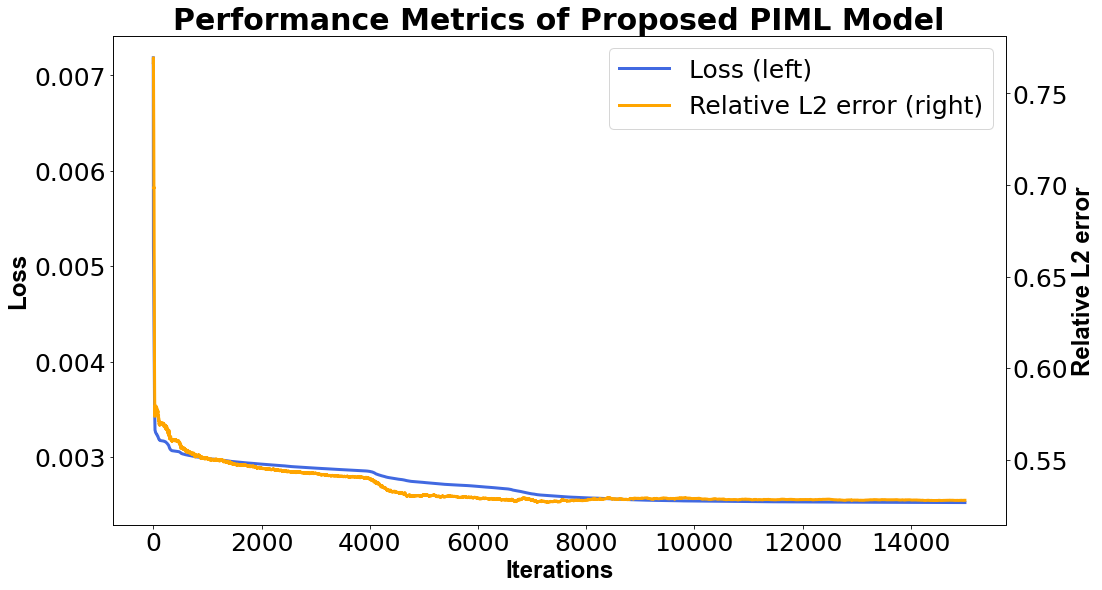

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.021201681753330107
MSE =  0.0031240751444680344
RMSE =  0.0558934266660046
L2 relative error = 0.5215239449448034
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

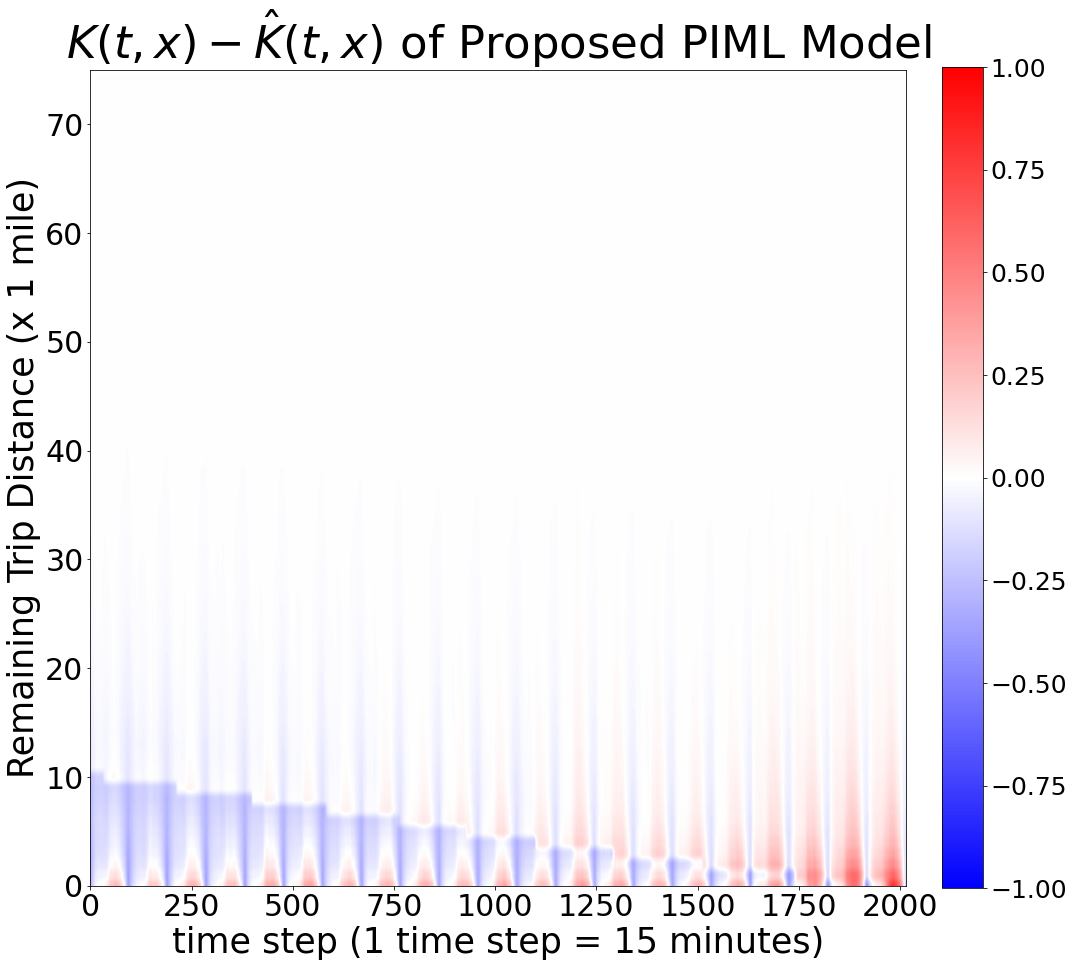

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

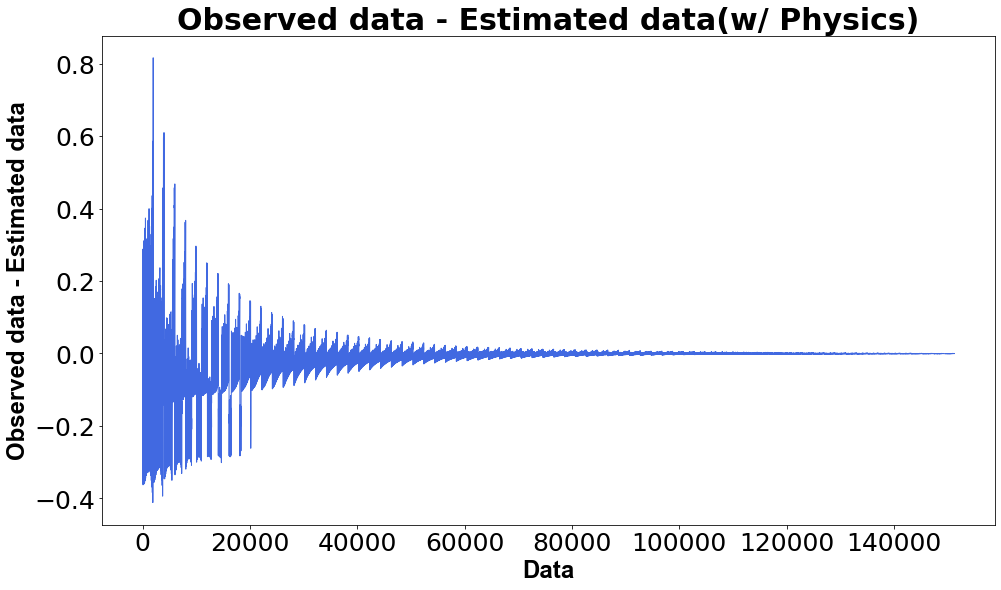

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

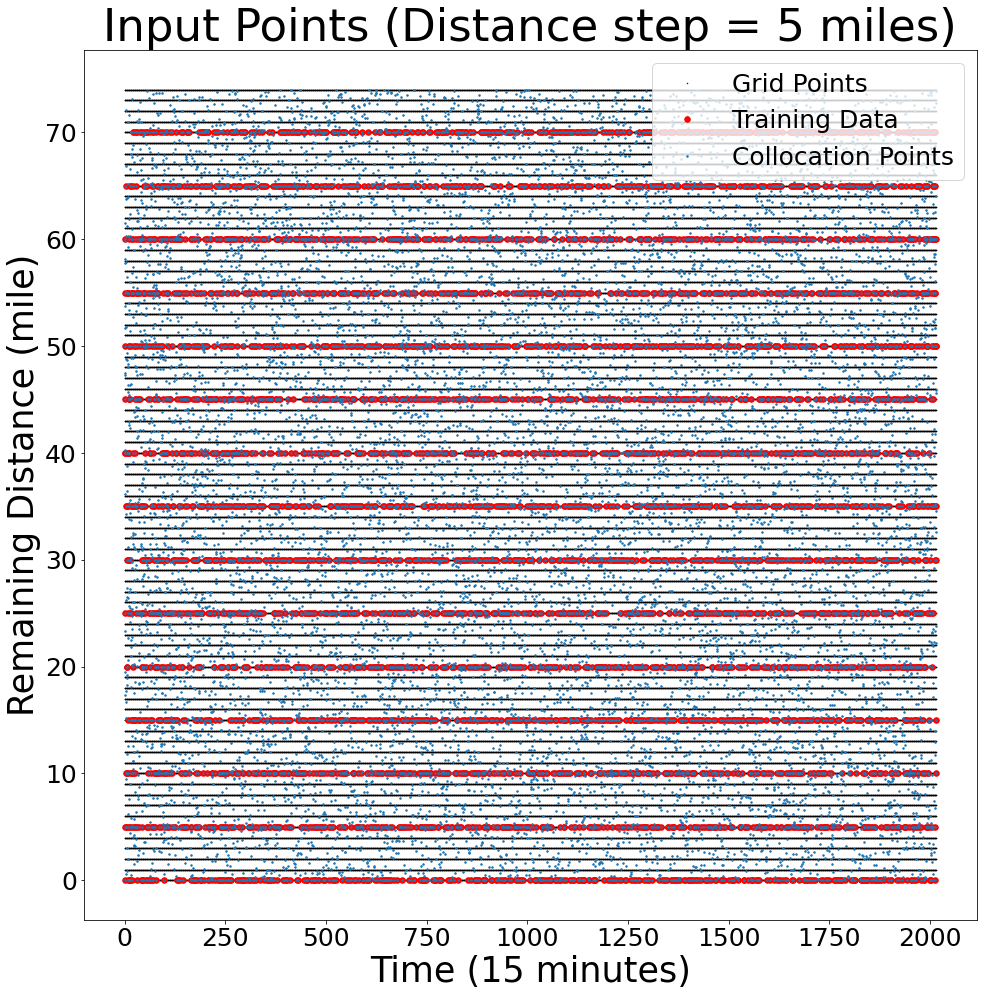

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

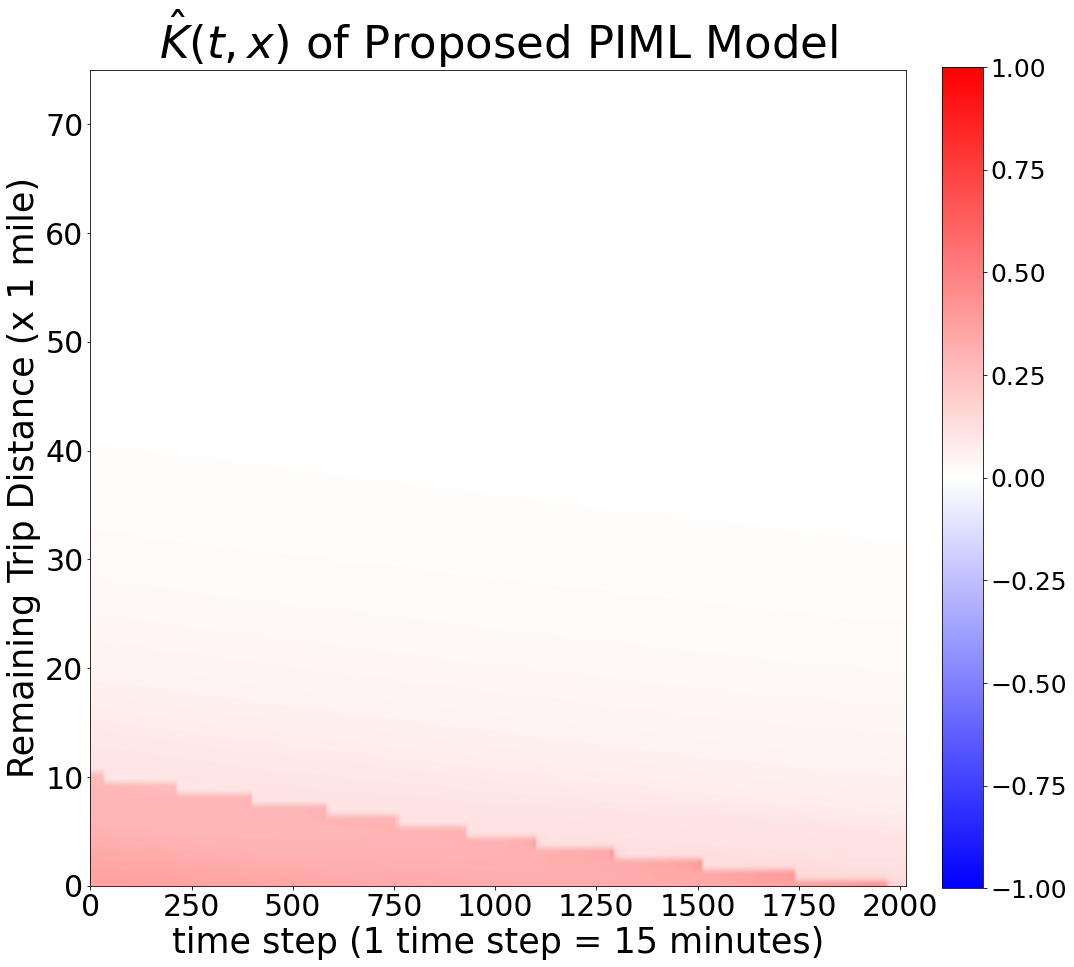

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)